This is a notebook that shows the code to solve the inverse kinematics problem of robot manipulators using neural networks. The analysis and solution  inverse kinematics problem of some of the top 5 popular and most widely used standard industrial robotic arms is first done to show the working algorithm.The angle range in radians were specified for each of these arms for generalization but the joint limits vary according to specific models and this can easily be adjusted according to the problem.

After analysis of the 5 standard arms, the solution procedure is then applied for the specific inverse kinematics problem of  live 4 dof arm.

The top 5 industry robotic arms analysed are;
- ABB IRB 1600
- Fanuc LR Mate 200iD
- Universal Robots UR10
- KUKA KR AGILUS
- Yasakawa Motoman GP series.

1. **ABB IRB 1600**

The first arm considered is the ABB IRB 1600. It is an industrial robot arm designed and manufactured by ABB Robotics, one of the world's leading robotics companies.

**Overview**:

The ABB IRB 1600 is a 6-degree-of-freedom (6-DOF) industrial robot arm, i.e it has six rotational joints that allow it to move in multiple directions.
It is designed for a wide range of manufacturing and automation applications, including welding, material handling, assembly, and more.It has compact design, high precision, and flexibility, making it suitable for various industries and production environments.

**Key Features**:

- Payload Capacity: The robot is available in various models with different payload capacities, typically ranging from 5 kg to 10 kg.
- Reach: The robot's horizontal reach is typically around 1.45 to 1.85 meters, allowing it to access a considerable workspace.
- Compact Design: The IRB 1600's compact size makes it suitable for installations and operations within limited space.
- Flexibility: The arm also offers a wide range of motion, enabling it to handle complex tasks and reach challenging positions.
- High Accuracy: The robot is designed for precise positioning and repeatability, ensuring consistent performance in critical applications.

**Brief History**:

The ABB IRB 1600 was introduced by ABB Robotics as part of its IRB 1600 series, and it has been in production for several years.
Over the years, ABB robotics company has continuously improved and updated the IRB 1600 series, introducing new features, enhancements, and variants to meet the needs of the evolving industry.

A picture of the arm can be shown below.

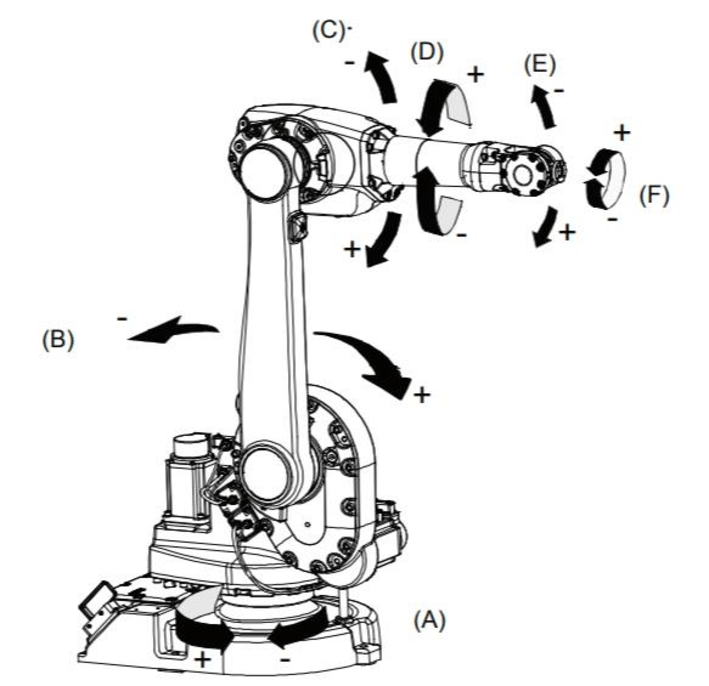

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/Geometric-model-of-the-robot-ABB-IRB-1600-6-12.png')

Since the ABB IRB 1600 robot arm has 6 degrees of freedom, the DH-parameter table of the arm is shown below.


In [2]:
from IPython.display import Image
Image('/content/drive/MyDrive/IMG_20230717_081333_725.jpg')

Output hidden; open in https://colab.research.google.com to view.

Now we generate the data used for training and testing the neural networks mode. The end effector positions are calculated from various joint angles for the robot arm.

Three of the DH (Denavit-hartenberg) parameters were gotten from the manufacuturer's specification. While the range of rotation of the revolute joints(the theta values) are specified depending on the problem application.

The theta values are specifiable seperately for each joint so the code can be easily tweaked depending on the application The data is exported and stored in a csv file. This data is what is split into training and test data to train and evaluate the Tensorflow model.

In [ ]:
# Import the necessary libraries.
import numpy as np
import math  # For mathematical operations.
import csv  # To save generated training and test data into a CSV file.

# Function to generate random angles within specified ranges.
def generate_joint_angles():
    '''
    This function generates random angles within specified ranges.
    The angle ranges should be specified in radians form.
    '''
    joint1 = np.random.uniform(0, np.pi)  # 0-180 degrees.
    joint2 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint3 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint4 = np.random.uniform(0, np.pi)  # 0-180 degrees.
    joint5 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint6 = np.random.uniform(0, np.pi)  # 0-180 degrees.
    return [joint1, joint2, joint3, joint4, joint5, joint6]

# Function that performs the forward kinematics of the robot manipulator.
def forward_kinematics(theta):
    '''
    This function takes in the theta values for the specific problem and calculates the corresponding end effector position.
    The theta values should be passed into the function in radians form too.
    '''
    # DH parameters for the ABB IRB 1600.
    a = [300, 1200, 250, 0, 0, 0]  # link lengths (mm).
    alpha = [np.pi/2, 0, np.pi/2, np.pi/2, np.pi/2, 0]  # link twists.
    d = [649, 0, 0, 1320, 0, 290]  # link offsets (mm).

    # Homogeneous transformation matrices.
    T = np.eye(4)  # initial transformation matrix (identity matrix).

    for i in range(len(theta)):
        # Call parameters for the transformation matrix.
        cos_theta = np.cos(theta[i])
        sin_theta = np.sin(theta[i])
        cos_alpha = np.cos(alpha[i])
        sin_alpha = np.sin(alpha[i])

        # Denavit-Hartenberg transformation matrix.
        A = np.array([[cos_theta, -sin_theta * cos_alpha, sin_theta * sin_alpha, a[i] * cos_theta],
                      [sin_theta, cos_theta * cos_alpha, -cos_theta * sin_alpha, a[i] * sin_theta],
                      [0, sin_alpha, cos_alpha, d[i]],
                      [0, 0, 0, 1]])

        # Update the transformation matrix.
        T = np.dot(T, A)

        # Extract the end effector position from the transformation matrix.
        end_effector_pos = T[:3, 3]

        # Create the quaternion representation of the XYZW-rotation.
        m_00 = T[0, 0]
        m_01 = T[0, 1]
        m_02 = T[0, 2]
        m_10 = T[1, 0]
        m_11 = T[1, 1]
        m_12 = T[1, 2]
        m_20 = T[2, 0]
        m_21 = T[2, 1]
        m_22 = T[2, 2]

        w = math.sqrt((1 + m_00 + m_11 + m_22) / 2)
        x = (m_21 - m_12) / (4 * w)
        y = (m_02 - m_20) / (4 * w)
        z = (m_10 - m_01) / (4 * w)

        quart = np.array([w, x, y, z])

        final_pos = np.concatenate((end_effector_pos, quart))
    return final_pos

# Generate 100,000 random sets of joint angles.
np.random.seed(123)  # For reproducibility.
joint_angles = np.array([generate_joint_angles() for _ in range(100000)])  # Generates angles separately for each joint.


# Calculate forward kinematics for each set of joint angles.
final_positions = []
for angles in joint_angles:
    position = forward_kinematics(angles)
    final_positions.append(position)

final_positions = np.array(final_positions)

# Combine joint angles and end effector positions.
data = np.hstack((joint_angles, final_positions))  # Horizontally stack up the joint parameters with the corresponding end effector position

# Save joint angles and end effector positions to a CSV file
with open('joint_positions_abb.csv', 'w', newline='') as file: #The `newline` argument is used to ensure that the CSV file is written with consistent newline characters.
    writer = csv.writer(file)
    writer.writerow(['Joint1', 'Joint2', 'Joint3', 'Joint4', 'Joint5', 'Joint6', 'X', 'Y', 'Z', 'q1', 'q2', 'q3', 'q4'])  # Write header with xyz being the end effector position in space and q1, q2, q3, q4 representing the quarternion representations.
    writer.writerows(data)  # Writes rows of entries to the csv file from the data we stacked using `np.hstack()`.

print("CSV file generated successfully.")

CSV file generated successfully.


The training and test data contains various joint parameters for the ABB IRB robot arm and the corresponding end effector position these joint parameters will give.

Two tensorflow models were used. Both were trained on the input data (the end effector positions and quarternion representation data). But the first model was used to predict the revolute joint angles of the first three joints while the second model was used to predict the joint angles of the last three joints. This was done to improve the ability of the models to find patterns within the data. Tje output of both models is then combined together.

The Tensorflow model will solve the inverse kinematics by taking in a specified end effector position as input and predicting the corresponding various joint parameters that would give the end effector position.

In [ ]:
# Import the necessary libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Load the CSV data.
data = pd.read_csv('/content/drive/MyDrive/joint_positions_abb (3).csv')

# Split features (input) and labels (output).
features = data.iloc[:, -7:].values  # Last 7 columns are features.
labels = data.iloc[:, :-7].values    # First 6 columns are labels.

# Split data into training, validation, and test sets.
x_train, x_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42)

# Define the first TensorFlow model for the first four outputs.
abb_model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)  # Output the first four values.
])

# Define the second TensorFlow model for the last three outputs.
abb_model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)  # Output the last three values.
])

# Compile both models.
optimizer_1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer_2 = tf.keras.optimizers.Adam(learning_rate=0.001)
abb_model1.compile(optimizer=optimizer_1, loss='mean_squared_error')
abb_model2.compile(optimizer=optimizer_2, loss='mean_squared_error')

# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train model1.
print("Training abb model1...")
abb_model1.fit(x_train, y_train[:, :3], epochs=20, batch_size=32, validation_data=(x_test, y_test[:, :3]), callbacks=[early_stopping])
print("Training of abb model1 completed.")

# Train model2.
print("Training abb model2...")
abb_model2.fit(x_train, y_train[:, 3:], epochs=20, batch_size=32, validation_data=(x_test, y_test[:, 3:]), callbacks=[early_stopping])
print("Training of abb model2 completed.")

# Make predictions using both models.
y_preds1 = abb_model1.predict(x_test)
y_preds2 = abb_model2.predict(x_test)

# Combine the predictions to form the final prediction variable.
abb_final_predictions = np.hstack((y_preds1, y_preds2))

# Evaluate the combined model's performance
mse = np.mean(np.square(abb_final_predictions - y_test))
print('Mean Squared Error (Combined Model):', mse)

# Calculate the mean of the actual target values from the test set (mean_y_test).
mean_y_test = np.mean(y_test, axis=0)

# Calculate the total sum of squares (TSS).
TSS = np.sum(np.square(y_test - mean_y_test))

# Calculate the RSS (residual sum of squares).
RSS = np.sum(np.square(y_test - abb_final_predictions))

# Calculate R-squared (R²).
R_squared = 1 - (RSS / TSS)

print("R-squared value:", R_squared)

Training abb model1...
Epoch 1/20
2500/2500 [==============================] - 28s 11ms/step - loss: 0.5761 - val_loss: 0.0739
Epoch 2/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.0624 - val_loss: 0.0531
Epoch 3/20
2500/2500 [==============================] - 22s 9ms/step - loss: 0.0544 - val_loss: 0.0458
Epoch 4/20
2500/2500 [==============================] - 23s 9ms/step - loss: 0.0483 - val_loss: 0.0445
Epoch 5/20
2500/2500 [==============================] - 23s 9ms/step - loss: 0.0475 - val_loss: 0.0459
Epoch 6/20
2500/2500 [==============================] - 24s 9ms/step - loss: 0.0444 - val_loss: 0.0405
Epoch 7/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.0404 - val_loss: 0.0419
Epoch 8/20
2500/2500 [==============================] - 24s 10ms/step - loss: 0.0378 - val_loss: 0.0338
Epoch 9/20
2500/2500 [==============================] - 22s 9ms/step - loss: 0.0352 - val_loss: 0.0378
Epoch 10/20
2500/2500 [=======================

### Save the ABB arm models.

In [ ]:
# Save the abb models to a file.
abb_model1.save('abb_model1.h5')
abb_model2.save('abb_model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Save the ABB arm predicted data.

In [ ]:
import pandas as pd

# Convert the NumPy array to a DataFrame.
abb_predicted_data = pd.DataFrame(abb_final_predictions, columns=['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6'])

# Save the DataFrame to a CSV file.
abb_predicted_data.to_csv('abb_predicted_data.csv', index=False)

### Save the ABB arm test data.

In [ ]:
import pandas as pd

# Convert the NumPy array to a DataFrame.
abb_test_data = pd.DataFrame(y_test, columns=['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6'])

# Save the DataFrame to a CSV file.
abb_test_data.to_csv('abb_test_data.csv', index=False)

Abb forward_kinematics function

In [ ]:
# Create a function that performs the forward kinematics of the robot manipulator.
def forward_kinematics(theta):
    '''
    This function takes in the theta values for the specific problem and calculates the corresponding end effector position.
    The theta values should be passed into the function in radians form too.
    '''
    # DH parameters for the ABB IRB 1600.
    a = [300, 1200, 250, 0, 0, 0]  # link lengths (mm).
    alpha = [np.pi/2, 0, np.pi/2, np.pi/2, np.pi/2, 0]  # link twists.
    d = [649, 0, 0, 1320, 0, 290]  # link offsets (mm).

    # Homogeneous transformation matrices.
    T = np.eye(4)  # initial transformation matrix (identity matrix).

    for i in range(len(theta)):
        # Call parameters for the transformation matrix.
        cos_theta = np.cos(theta[i])
        sin_theta = np.sin(theta[i])
        cos_alpha = np.cos(alpha[i])
        sin_alpha = np.sin(alpha[i])

        # Denavit-Hartenberg transformation matrix.
        A = np.array([[cos_theta, -sin_theta * cos_alpha, sin_theta * sin_alpha, a[i] * cos_theta],
                      [sin_theta, cos_theta * cos_alpha, -cos_theta * sin_alpha, a[i] * sin_theta],
                      [0, sin_alpha, cos_alpha, d[i]],
                      [0, 0, 0, 1]])

        # Update the transformation matrix.
        T = np.dot(T, A)

        # Extract the end effector position from the transformation matrix.
        end_effector_pos = T[:3, 3]

        # Create the quaternion representation of the XYZW-rotation.
        m_00 = T[0, 0]
        m_01 = T[0, 1]
        m_02 = T[0, 2]
        m_10 = T[1, 0]
        m_11 = T[1, 1]
        m_12 = T[1, 2]
        m_20 = T[2, 0]
        m_21 = T[2, 1]
        m_22 = T[2, 2]

        w = math.sqrt((1 + m_00 + m_11 + m_22) / 2)
        x = (m_21 - m_12) / (4 * w)
        y = (m_02 - m_20) / (4 * w)
        z = (m_10 - m_01) / (4 * w)

        quart = np.array([w, x, y, z])

        final_pos = np.concatenate((end_effector_pos, quart))
    return final_pos

Load predicted and test data.

In [ ]:
import pandas as pd

abb_predicted_data = pd.read_csv('/content/drive/MyDrive/abb_predicted_data.csv')
abb_test_data = pd.read_csv('/content/drive/MyDrive/abb_test_data.csv')

Combine xyz positions of predicted and actual data into one csv file.

In [ ]:
import numpy as np
import math
# Create empty lists to store end-effector positions.
x_predicted = []
y_predicted = []
z_predicted = []
x_actual = []
y_actual = []
z_actual = []

# Iterate through the rows of both datasets.
for index, row in abb_predicted_data.iterrows():
    # Extract joint angles from the dataset row.
    joint_angles_predicted = row[['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6']]
    joint_angles_actual = abb_test_data.loc[index, ['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6']]

    # Calculate end-effector positions using forward kinematics.
    end_effector_pos_predicted = forward_kinematics(joint_angles_predicted)[:3]
    end_effector_pos_actual = forward_kinematics(joint_angles_actual)[:3]

    # Append the calculated positions to the lists.
    x_predicted.append(end_effector_pos_predicted[0])
    y_predicted.append(end_effector_pos_predicted[1])
    z_predicted.append(end_effector_pos_predicted[2])
    x_actual.append(end_effector_pos_actual[0])
    y_actual.append(end_effector_pos_actual[1])
    z_actual.append(end_effector_pos_actual[2])

# Create a new DataFrame with the calculated end-effector positions.
result_df = pd.DataFrame({
    'x_predicted': x_predicted,
    'y_predicted': y_predicted,
    'z_predicted': z_predicted,
    'x_actual': x_actual,
    'y_actual': y_actual,
    'z_actual': z_actual
})

# Save the combined DataFrame to a CSV file.
result_df.to_csv('abb_end_effector_positions.csv', index=False)


Create a 3D plot to show deviation of predicted values from actual values.

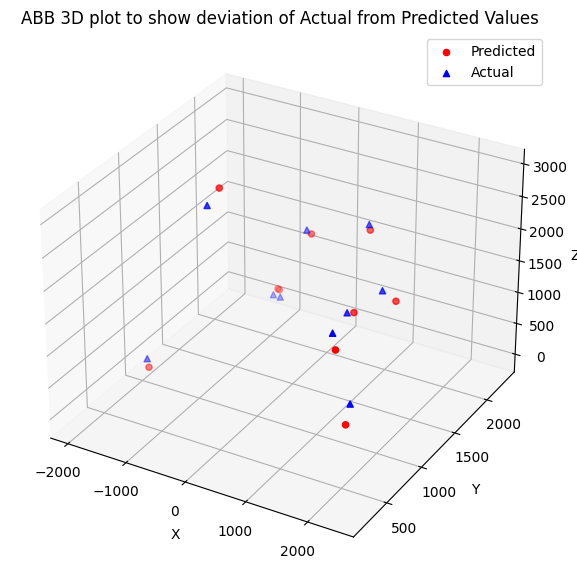

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

abb_result_df = result_df
# Limit the plot to the first 5 rows.
abb_result_df_first_5 = abb_result_df.head(10)

# Create a 3D scatter plot.
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Extract the columns for predicted and actual coordinates for the first 20 rows.
x_predicted = abb_result_df_first_5['x_predicted']
y_predicted = abb_result_df_first_5['y_predicted']
z_predicted = abb_result_df_first_5['z_predicted']
x_actual = abb_result_df_first_5['x_actual']
y_actual = abb_result_df_first_5['y_actual']
z_actual = abb_result_df_first_5['z_actual']

# Plot predicted positions as red points.
ax.scatter(x_predicted, y_predicted, z_predicted, c='red', label='Predicted', marker='o')

# Plot actual positions as blue points.
ax.scatter(x_actual, y_actual, z_actual, c='blue', label='Actual', marker='^')

# Set labels and legend.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(['Predicted', 'Actual'])

# Add a title to the plot.
plt.title('ABB 3D plot to show deviation of Actual from Predicted Values')

# Show the 3D plot.
plt.show()


2. **The fanuc LR Mate 200iC**

The FANUC LR Mate 200iC is an industrial robotic arm developed by FANUC Corporation, a Japanese robotics company. It is known for its compact size, high precision, and versatility in a wide range of industrial applications. The LR Mate 200ic is designed to perform various tasks, including material handling, assembly, and machine tending.

**Overview**:

- Compact Size: The LR Mate 200iC is known for its small footprint, making it suitable for tight workspaces.
- Six Degrees of Freedom: The LR Mate 200iC has six axes of motion, allowing it to move in multiple directions and achieve complex motions.
- High Payload Capacity: Despite its compact size, this robotic arm can handle payloads of up to 7 kg, making it capable of handling various objects and components.
- Reach and Working Envelope: The LR Mate 200iC has a reach of around 911 mm and a maximum working envelope of approximately 1,027 mm.
- User-Friendly Interface: It is equipped with FANUC's user-friendly R-30iB Mate Plus controller, which simplifies programming and operation for users.

**History**:
The LR Mate series has a long history, and the 200iC model is an evolution of earlier LR Mate models. The first LR Mate robot, the LR Mate 200iC, was introduced in 1992. It was one of the first robots to feature an integrated mechanical and control unit, making it highly compact and easy to install.


Over the years, FANUC continued to refine and enhance the LR Mate series, introducing various models with improved capabilities, enhanced performance, and new features. The LR Mate 200iC, released around the mid-2000s, represented a significant advancement in the series, incorporating improved motion control, higher payload capacity, and better overall performance.

A picture of the arm can be shown below.

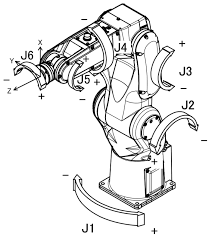

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/the_anuc_LR_Mate_200iD.png')

Since the Fanuc robot arm also has 6 degrees of freedom, the DH-parameter table of the arm is shown below.


In [3]:
from IPython.display import Image
Image('/content/drive/MyDrive/dh_fanuc.jpg')

Output hidden; open in https://colab.research.google.com to view.

The end effector positions from various joint angles for the FANUC LR mate 200iC industrial robot arm is generated also using joint restrictions from the manufacturer's manual and the data is exported and stored in a csv file. This data is what is split into training and test data to train and evaluate the Tensorflow model.

Similar approach was used here as in the first `abb` arm.

In [ ]:
#Import the necessary libraries.
import numpy as np
import math # For mathematical operations.
import csv #To save generated training and test data into a csv file.


# Function to generate random angles within specified ranges.
def generate_joint_angles():
    '''
    This function generates random angles within specified ranges.
    The angle ranges should be specified in radians form.
    '''
    joint1 = np.random.uniform(0, np.pi)  # 0-180 degrees.
    joint2 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint3 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint4 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint5 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint6 = np.random.uniform(0, np.pi)  # 0-180 degrees.
    return [joint1, joint2, joint3, joint4, joint5, joint6]

# Function that performs the forward kinematics of the robot manipulator.
def forward_kinematics(theta):
    '''
    This function takes in the theta values for the specific problem and calculates the corresponding end effector position.
    The theta values should be passed into the function in radians form too.
    '''
    # DH parameters for the Fanuc Lr mate 200iC AGILUS.
    a = [75, 300, -75, 0, 0, 0]  # link lengths (mm).
    alpha = [-np.pi/2, np.pi, np.pi/2, -np.pi/2, np.pi/2, np.pi]  # link twists.
    d = [330,0 , 0, -320, 0, -80]  # link offsets (mm).

    # Homogeneous transformation matrices.
    T = np.eye(4)  # initial transformation matrix(identity matrix).

    for i in range(len(theta)):
        # Call parameters for transformation matrix.
        cos_theta = np.cos(theta[i])
        sin_theta = np.sin(theta[i])
        cos_alpha = np.cos(alpha[i])
        sin_alpha = np.sin(alpha[i])

        # Denavit-Hartenberg transformation matrix.
        A = np.array([[cos_theta, -sin_theta*cos_alpha, sin_theta*sin_alpha, a[i]*cos_theta],
                      [sin_theta, cos_theta*cos_alpha, -cos_theta*sin_alpha, a[i]*sin_theta],
                      [0, sin_alpha, cos_alpha, d[i]],
                      [0, 0, 0, 1]])

        # Update transformation matrix.
        T = np.dot(T, A)

        # Extract end effector position from the transformation matrix.
        end_effector_pos = T[:3, 3]
        # Create the quarternion representation of the XYZW-rotation.
        m_00 = T[0, 0]
        m_01 = T[0, 1]
        m_02 = T[0, 2]
        m_10 = T[1, 0]
        m_11 = T[1, 1]
        m_12 = T[1, 2]
        m_20 = T[2, 0]
        m_21 = T[2, 1]
        m_22 = T[2, 2]

        w = math.sqrt((1 + m_00 + m_11 + m_22)/2)
        x = (m_21 - m_12)/(4 * w)
        y = (m_02 - m_20)/(4 * w)
        z = (m_10 - m_01)/(4 * w)

        quart = np.array([w, x, y, z])

        final_pos = np.concatenate((end_effector_pos, quart))
    return final_pos

# Generate 100,000 random sets of joint angles.
np.random.seed(123)  # For reproducibility.
joint_angles = np.array([generate_joint_angles() for _ in range(100000)])  # Generate angles separately for each joint.

# Calculate forward kinematics for each set of joint angles.
final_positions = []
for angles in joint_angles:  #The angles variable has 6 entries which are angles for each joint in the manipulator.
    position = forward_kinematics(angles)
    final_positions.append(position)

final_positions = np.array(final_positions)

# Combine joint angles and end effector positions.
data = np.hstack((joint_angles, final_positions)) #Horizontally stacks up the joint parameters with the corresponding end effector position produced.

# Save joint angles and end effector positions to CSV file.
with open('joint_positions_fanuc.csv', 'w', newline='') as file: #The `newline` argument is used to ensure that the CSV file is written with consistent newline characters.
    writer = csv.writer(file) #To write to the csv file.
    writer.writerow(['Joint1', 'Joint2', 'Joint3', 'Joint4', 'Joint5', 'Joint6', 'X', 'Y', 'Z', 'q1', 'q2', 'q3', 'q4'])  # Write header with xyz being the end effector position in space and q1, q2, q3, q4 representing the quarternion representations.
    writer.writerows(data) # Writes rows of entries to the csv file from the data we stacked using `np.hstack()`.

print("CSV file generated successfully.")

CSV file generated successfully.


The training and test data contains various joint parameters for this robot arm and the corresponding end effector position these joint parameters will give.

 This arm analysis also considered two TensorFlow models just like the for `abb` arm.

In [ ]:
#Import the necesarry libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


# Load the CSV data.
fanuc_data = pd.read_csv('/content/drive/MyDrive/joint_positions_fanuc.csv')

# Split features (input) and labels (output).
fanuc_labels = fanuc_data.iloc[:, :-7].values  # First 6 columns are labels.
fanuc_features = fanuc_data.iloc[:, -7:].values  # Last seven columns (x, y, z).

# Split data into training, validation, and test sets.
fanuc_x_train, fanuc_x_test, fanuc_y_train, fanuc_y_test = train_test_split(
    fanuc_features, fanuc_labels, test_size=0.2, random_state=42)

# Define the first TensorFlow model for the first four outputs.
fanuc_model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)  # Output the first four values.
])

# Define the second TensorFlow model for the last three outputs.
fanuc_model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)  # Output the last three values.
])


# Compile both models.
optimizer_1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer_2 = tf.keras.optimizers.Adam(learning_rate=0.001)
fanuc_model1.compile(optimizer=optimizer_1, loss='mean_squared_error')
fanuc_model2.compile(optimizer=optimizer_2, loss='mean_squared_error')

# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Train model1.
print("Training fanuc model1...")
fanuc_model1.fit(fanuc_x_train, fanuc_y_train[:, :3], epochs=20, batch_size=32, validation_data=(fanuc_x_test, fanuc_y_test[:, :3]), callbacks=[early_stopping])
print("Training of fanuc model1 completed.")

# Train model2.
print("Training fanuc model2...")
fanuc_model2.fit(fanuc_x_train, fanuc_y_train[:, 3:], epochs=20, batch_size=32, validation_data=(fanuc_x_test, fanuc_y_test[:, 3:]), callbacks=[early_stopping])
print("Training of fanuc model2 completed.")

# Make predictions using both models.
fanuc_y_preds1 = fanuc_model1.predict(fanuc_x_test)
fanuc_y_preds2 = fanuc_model2.predict(fanuc_x_test)

# Combine the predictions to form the final prediction variable.
fanuc_final_predictions = np.hstack((fanuc_y_preds1, fanuc_y_preds2))

# Evaluate the combined model's performance.
mse = np.mean(np.square(fanuc_final_predictions - fanuc_y_test))
print('Mean Squared Error (Combined Model):', mse)


# Calculate the mean of the actual target values from the test set (mean_y_test).
fanuc_mean_y_test = np.mean(fanuc_y_test, axis=0)

# Calculate the total sum of squares (TSS).
fanuc_TSS = np.sum(np.square(fanuc_y_test - fanuc_mean_y_test))

# Calculate the RSS (residual sum of squares).
fanuc_RSS = np.sum(np.square(fanuc_y_test - fanuc_final_predictions))

# Calculate R-squared (R²).
fanuc_R_squared = 1 - (fanuc_RSS / fanuc_TSS)

print("fanuc-R-squared value:", fanuc_R_squared)

Training fanuc model1...
Epoch 1/20
2500/2500 [==============================] - 34s 11ms/step - loss: 0.1298 - val_loss: 0.0631
Epoch 2/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.0518 - val_loss: 0.0388
Epoch 3/20
2500/2500 [==============================] - 23s 9ms/step - loss: 0.0404 - val_loss: 0.0318
Epoch 4/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.0324 - val_loss: 0.0246
Epoch 5/20
2500/2500 [==============================] - 26s 11ms/step - loss: 0.0238 - val_loss: 0.0200
Epoch 6/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.0169 - val_loss: 0.0165
Epoch 7/20
2500/2500 [==============================] - 26s 10ms/step - loss: 0.0150 - val_loss: 0.0153
Epoch 8/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.0134 - val_loss: 0.0131
Epoch 9/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.0123 - val_loss: 0.0188
Epoch 10/20
2500/2500 [=================

### Save the Fanuc arm models.

In [ ]:
# Save the fanuc models to a file.
fanuc_model1.save('fanuc_model1.h5')
fanuc_model2.save('fanuc_model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Save the Fanuc arm predicted data.

In [ ]:
import pandas as pd

# Convert the NumPy array to a DataFrame.
predicted_data = pd.DataFrame(fanuc_final_predictions, columns=['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6'])

# Save the DataFrame to a CSV file.
predicted_data.to_csv('fanuc_predicted_data.csv', index=False)


### Save the Fanuc arm test data.

In [ ]:
import pandas as pd

# Convert the NumPy array to a DataFrame.
fanuc_test_data = pd.DataFrame(fanuc_y_test, columns=['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6'])

# Save the DataFrame to a CSV file.
fanuc_test_data.to_csv('fanuc_test_data.csv', index=False)

Fanuc forward_kinematics function

In [ ]:
# Create a function that performs the forward kinematics of the robot manipulator.
def forward_kinematics(theta):
    '''
    This function takes in the theta values for the specific problem and calculates the corresponding end effector position.
    The theta values should be passed into the function in radians form too.
    '''
    # DH parameters for the Fanuc Lr mate 200iC AGILUS.
    a = [75, 300, -75, 0, 0, 0]  # link lengths (mm).
    alpha = [-np.pi/2, np.pi, np.pi/2, -np.pi/2, np.pi/2, np.pi]  # link twists.
    d = [330,0 , 0, -320, 0, -80]  # link offsets (mm).

    # Homogeneous transformation matrices.
    T = np.eye(4)  # initial transformation matrix(identity matrix).

    for i in range(len(theta)):
        # Call parameters for transformation matrix.
        cos_theta = np.cos(theta[i])
        sin_theta = np.sin(theta[i])
        cos_alpha = np.cos(alpha[i])
        sin_alpha = np.sin(alpha[i])

        # Denavit-Hartenberg transformation matrix.
        A = np.array([[cos_theta, -sin_theta*cos_alpha, sin_theta*sin_alpha, a[i]*cos_theta],
                      [sin_theta, cos_theta*cos_alpha, -cos_theta*sin_alpha, a[i]*sin_theta],
                      [0, sin_alpha, cos_alpha, d[i]],
                      [0, 0, 0, 1]])

        # Update transformation matrix.
        T = np.dot(T, A)

        # Extract end effector position from the transformation matrix.
        end_effector_pos = T[:3, 3]
        # Create the quarternion representation of the XYZW-rotation.
        m_00 = T[0, 0]
        m_01 = T[0, 1]
        m_02 = T[0, 2]
        m_10 = T[1, 0]
        m_11 = T[1, 1]
        m_12 = T[1, 2]
        m_20 = T[2, 0]
        m_21 = T[2, 1]
        m_22 = T[2, 2]

        w = math.sqrt((1 + m_00 + m_11 + m_22)/2)
        x = (m_21 - m_12)/(4 * w)
        y = (m_02 - m_20)/(4 * w)
        z = (m_10 - m_01)/(4 * w)

        quart = np.array([w, x, y, z])

        final_pos = np.concatenate((end_effector_pos, quart))
    return final_pos

Load predicted and test data.

In [ ]:
import pandas as pd

fanuc_predicted_data = pd.read_csv('/content/drive/MyDrive/fanuc_predicted_data.csv')
fanuc_test_data = pd.read_csv('/content/drive/MyDrive/fanuc_test_data.csv')

Load and Combine predicted and test data into one csv file

In [ ]:
import numpy as np
import math
# Create empty lists to store end-effector positions.
x_predicted = []
y_predicted = []
z_predicted = []
x_actual = []
y_actual = []
z_actual = []

# Iterate through the rows of both datasets.
for index, row in fanuc_predicted_data.iterrows():
    # Extract joint angles from the dataset row.
    joint_angles_predicted = row[['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6']]
    joint_angles_actual = fanuc_test_data.loc[index, ['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6']]

    # Calculate end-effector positions using forward kinematics.
    end_effector_pos_predicted = forward_kinematics(joint_angles_predicted)[:3]
    end_effector_pos_actual = forward_kinematics(joint_angles_actual)[:3]

    # Append the calculated positions to the lists.
    x_predicted.append(end_effector_pos_predicted[0])
    y_predicted.append(end_effector_pos_predicted[1])
    z_predicted.append(end_effector_pos_predicted[2])
    x_actual.append(end_effector_pos_actual[0])
    y_actual.append(end_effector_pos_actual[1])
    z_actual.append(end_effector_pos_actual[2])

# Create a new DataFrame with the calculated end-effector positions.
fanuc_result_df = pd.DataFrame({
    'x_predicted': x_predicted,
    'y_predicted': y_predicted,
    'z_predicted': z_predicted,
    'x_actual': x_actual,
    'y_actual': y_actual,
    'z_actual': z_actual
})

# Save the combined DataFrame to a CSV file.
fanuc_result_df.to_csv('fanuc_end_effector_positions.csv', index=False)


Create a 3D plot to show the deviations of predicted end effector positions from actual end effector positions.

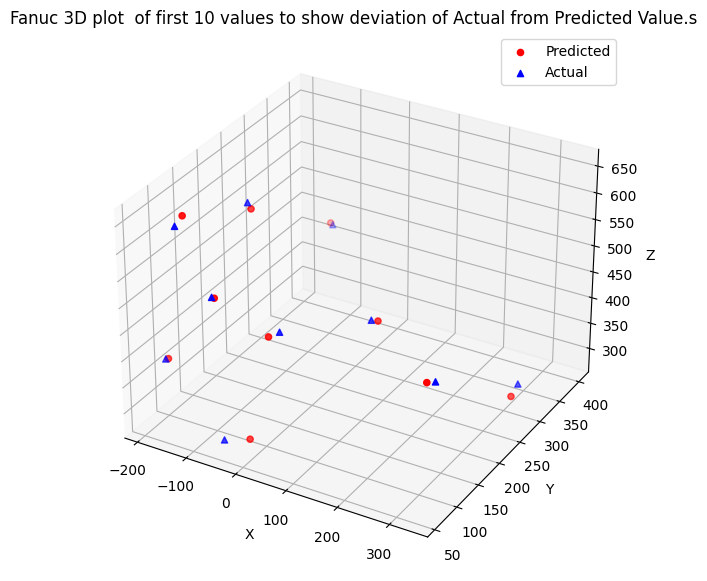

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Limit the plot to the first 5 rows.
fanuc_result_df_first_5 = fanuc_result_df.head(10)

# Create a 3D scatter plot.
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Extract the columns for predicted and actual coordinates for the first 20 rows.
x_predicted = fanuc_result_df_first_5['x_predicted']
y_predicted = fanuc_result_df_first_5['y_predicted']
z_predicted = fanuc_result_df_first_5['z_predicted']
x_actual = fanuc_result_df_first_5['x_actual']
y_actual = fanuc_result_df_first_5['y_actual']
z_actual = fanuc_result_df_first_5['z_actual']

# Plot predicted positions as red points.
ax.scatter(x_predicted, y_predicted, z_predicted, c='red', label='Predicted', marker='o')

# Plot actual positions as blue points.
ax.scatter(x_actual, y_actual, z_actual, c='blue', label='Actual', marker='^')

# Set labels and legend.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(['Predicted', 'Actual'])

# Add a title to the plot.
plt.title('Fanuc 3D plot  of first 10 values to show deviation of Actual from Predicted Values')

# Show the 3D plot.
plt.show()


3. **The Universal robot Ur10**

**Overview of Universal Robots UR10**:
The Universal Robots UR10 is a collaborative robotic arm designed and manufactured by Universal Robots, a Danish robotics company. The UR10 is part of Universal Robots' line of collaborative robots, also known as cobots. These robots are intended to work safely alongside humans in various industrial and commercial applications, enhancing productivity and flexibility in manufacturing environments.

**Key Features of Universal Robots UR10**:

- Collaborative Capability
- Six Degrees of Freedom
- Payload Capacity
- Easy Programming
- Plug-and-Play Integration
- Compact Design
- Versatile Applications

**History of Universal Robots UR10**:
Universal Robots was founded in 2005 by three Danish engineers, Esben Østergaard, Kasper Støy, and Kristian Kassow. The company's mission was to develop and produce safe, easy-to-use, and cost-effective collaborative robots that can work alongside humans. The UR10 was introduced as part of Universal Robots' first product line in 2008, along with the smaller UR5 and UR3 models. The UR10 was the largest and most powerful in the series, catering to applications requiring higher payload capacities and a larger working range.

Since its introduction, the Universal Robots UR10 has gained popularity and widespread adoption in various industries, such as automotive, electronics, pharmaceuticals, and general manufacturing. The company continued to refine and enhance its robot models with improved hardware, software, and safety features to meet the evolving needs of collaborative automation.

A picture of the arm is shown below;

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/ur10.png')

Output hidden; open in https://colab.research.google.com to view.

This industrial arm also has 6 degrees of freedom and the dh-parameter table is shown below;

In [6]:
from IPython.display import Image
Image('/content/drive/MyDrive/dh_ur10.jpg')

Output hidden; open in https://colab.research.google.com to view.

The end effector positions from various joint angles for this robot arm is generated also using joint restrictions from the manufacturer's manual and the data is exported and stored in a csv file. This data is what is split into training and test data to train and evaluate the Tensorflow model.

Similar approach was used here as in the first `abb` arm.

In [ ]:
# Import the necessary libraries.
import numpy as np
import math # For mathematical operations.
import csv #To save generated training and test data into a csv file.


# Function to generate random angles within specified ranges.
def generate_joint_angles():
    '''
    This function generates random angles within specified ranges.
    The angle ranges should be specified in radians form.
    '''
    joint1 = np.random.uniform(0, np.pi)  # 0-180 degrees.
    joint2 = np.random.uniform(0, np.pi)  # 0-180 degrees.
    joint3 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint4 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint5 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint6 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    return [joint1, joint2, joint3, joint4, joint5, joint6]

# Function that performs the forward kinematics of the robot manipulator.
def forward_kinematics(theta):
    '''
    This function takes in the theta values for the specific problem and calculates the corresponding end effector position.
    The theta values should be passed into the function in radians form too.
    '''
    # DH parameters for the KUKA KR5 AGILUS.
    a = [0, 612, 572, 0, 0, 0]  # link lengths (mm).
    alpha = [np.pi/2, 0, 0, np.pi/2, -np.pi/2, 0]  # link twists.
    d = [127, 0, 0, 164, 115, 92]  # link offsets (mm).

    # Homogeneous transformation matrices.
    T = np.eye(4)  # initial transformation matrix(identity matrix).

    for i in range(len(theta)):
        # Call parameters for transformation matrix.
        cos_theta = np.cos(theta[i])
        sin_theta = np.sin(theta[i])
        cos_alpha = np.cos(alpha[i])
        sin_alpha = np.sin(alpha[i])

        # Denavit-Hartenberg transformation matrix.
        A = np.array([[cos_theta, -sin_theta*cos_alpha, sin_theta*sin_alpha, a[i]*cos_theta],
                      [sin_theta, cos_theta*cos_alpha, -cos_theta*sin_alpha, a[i]*sin_theta],
                      [0, sin_alpha, cos_alpha, d[i]],
                      [0, 0, 0, 1]])

        # Update transformation matrix.
        T = np.dot(T, A)

        # Extract end effector position from the transformation matrix.
        end_effector_pos = T[:3, 3]
        # Create the quarternion representation of the XYZW-rotation.
        m_00 = T[0, 0]
        m_01 = T[0, 1]
        m_02 = T[0, 2]
        m_10 = T[1, 0]
        m_11 = T[1, 1]
        m_12 = T[1, 2]
        m_20 = T[2, 0]
        m_21 = T[2, 1]
        m_22 = T[2, 2]

        w = math.sqrt((1 + m_00 + m_11 + m_22)/2)
        x = (m_21 - m_12)/(4 * w)
        y = (m_02 - m_20)/(4 * w)
        z = (m_10 - m_01)/(4 * w)

        quart = np.array([w, x, y, z])

        final_pos = np.concatenate((end_effector_pos, quart))
    return final_pos

# Generate 100,000 random sets of joint angles.
np.random.seed(123)  # For reproducibility.
joint_angles = np.array([generate_joint_angles() for _ in range(100000)])  # Generate angles separately for each joint.


# Calculate forward kinematics for each set of joint angles.
final_positions = []
for angles in joint_angles:  #The angles variable has 6 entries which are angles for each joint in the manipulator.
    position = forward_kinematics(angles)
    final_positions.append(position)

final_positions = np.array(final_positions)

# Combine joint angles and end effector positions.
data = np.hstack((joint_angles, final_positions)) #Horizontally stacks up the joint parameters with the corresponding end effector position produced.

# Save joint angles and end effector positions to CSV file
with open('joint_positions_ur10.csv', 'w', newline='') as file: #The `newline` argument is used to ensure that the CSV file is written with consistent newline characters.
    writer = csv.writer(file) #To write to the csv file.
    writer.writerow(['Joint1', 'Joint2', 'Joint3', 'Joint4', 'Joint5', 'Joint6', 'X', 'Y', 'Z', 'q1', 'q2', 'q3', 'q4'])  # Write header with xyz being the end effector position in space and q1, q2, q3, q4 representing the quarternion representations.
    writer.writerows(data) # Writes rows of entries to the csv file from the data we stacked using `np.hstack()`.

print("CSV file generated successfully.")

CSV file generated successfully.


The training and test data contains various joint parameters for this robot arm and the corresponding end effector position these joint parameters will give.

 This arm analysis also considered two TensorFlow models just like the for `abb` arm.

In [ ]:
# Import the necesarry libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Load the CSV data.
ur10_data = pd.read_csv('/content/drive/MyDrive/joint_positions_ur10.csv')

# Split features (input) and labels (output).
ur10_labels = ur10_data.iloc[:, :-7].values # First 6 columns are labels.
ur10_features = ur10_data.iloc[:, -7:].values  # Last seven columns (x, y, z).

# Split data into training, validation, and test sets.
ur10_x_train, ur10_x_test, ur10_y_train, ur10_y_test = train_test_split(
    ur10_features, ur10_labels, test_size=0.2, random_state=42)

# Define the first TensorFlow model for the first four outputs.
ur10_model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)  # Output the first four values.
])

# Define the second TensorFlow model for the last three outputs.
ur10_model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)  # Output the last three values.
])

# Compile both models.
optimizer_1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer_2 = tf.keras.optimizers.Adam(learning_rate=0.001)
ur10_model1.compile(optimizer=optimizer_1, loss='mean_squared_error')
ur10_model2.compile(optimizer=optimizer_2, loss='mean_squared_error')


# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)



# Train model1.
print("Training ur10 model1...")
ur10_model1.fit(ur10_x_train, ur10_y_train[:, :3], epochs=20, batch_size=32, validation_data=(ur10_x_test, ur10_y_test[:, :3]), callbacks=[early_stopping])
print("Training of ur10 model1 completed.")

# Train model2.
print("Training ur10 model2...")
ur10_model2.fit(ur10_x_train, ur10_y_train[:, 3:], epochs=20, batch_size=32, validation_data=(ur10_x_test, ur10_y_test[:, 3:]), callbacks=[early_stopping])
print("Training of ur10 model2 completed.")

# Make predictions using both models.
ur10_y_preds1 = ur10_model1.predict(ur10_x_test)
ur10_y_preds2 = ur10_model2.predict(ur10_x_test)

# Combine the predictions to form the final prediction variable.
ur10_final_predictions = np.hstack((ur10_y_preds1, ur10_y_preds2))

# Evaluate the combined model's performance.
mse = np.mean(np.square(ur10_final_predictions - ur10_y_test))
print('Mean Squared Error (Combined Model):', mse)


# Calculate the mean of the actual target values from the test set (mean_y_test).
ur10_mean_y_test = np.mean(ur10_y_test, axis=0)

# Calculate the total sum of squares (TSS).
ur10_TSS = np.sum(np.square(ur10_y_test - ur10_mean_y_test))

# Calculate the RSS (residual sum of squares).
ur10_RSS = np.sum(np.square(ur10_y_test - ur10_final_predictions))

# Calculate R-squared (R²).
ur10_R_squared = 1 - (ur10_RSS / ur10_TSS)

print("ur10_R-squared value:", ur10_R_squared)

Training ur10 model1...
Epoch 1/20
2500/2500 [==============================] - 26s 9ms/step - loss: 0.2606 - val_loss: 0.1917
Epoch 2/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.1837 - val_loss: 0.1595
Epoch 3/20
2500/2500 [==============================] - 27s 11ms/step - loss: 0.1148 - val_loss: 0.0515
Epoch 4/20
2500/2500 [==============================] - 24s 10ms/step - loss: 0.0653 - val_loss: 0.0450
Epoch 5/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.0495 - val_loss: 0.0298
Epoch 6/20
2500/2500 [==============================] - 26s 10ms/step - loss: 0.0461 - val_loss: 0.0335
Epoch 7/20
2500/2500 [==============================] - 26s 10ms/step - loss: 0.0431 - val_loss: 0.0497
Epoch 8/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.0380 - val_loss: 0.0247
Epoch 9/20
2500/2500 [==============================] - 24s 9ms/step - loss: 0.0357 - val_loss: 0.0312
Epoch 10/20
2500/2500 [===================

Save the UR10 models.

In [ ]:
# Save the ur1o models to a file.
ur10_model1.save('ur10_model1.h5')
ur10_model2.save('ur10_model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Save the UR10 predicted data.

In [ ]:
import pandas as pd

# Convert the NumPy array to a DataFrame.
predicted_data = pd.DataFrame(ur10_final_predictions, columns=['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6'])

# Save the DataFrame to a CSV file.
predicted_data.to_csv('ur10-_predicted_data.csv', index=False)


### Save the UR10 test data.

In [ ]:
import pandas as pd

# Convert the NumPy array to a DataFrame.
ur10_test_data = pd.DataFrame(ur10_y_test, columns=['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6'])

# Save the DataFrame to a CSV file.
ur10_test_data.to_csv('ur10_test_data.csv', index=False)


Fanuc forward_kinematics function

In [ ]:
# Create a function that performs the forward kinematics of the robot manipulator.
def forward_kinematics(theta):
    '''
    This function takes in the theta values for the specific problem and calculates the corresponding end effector position.
    The theta values should be passed into the function in radians form too.
    '''
    # DH parameters for the KUKA KR5 AGILUS
    a = [0, 612, 572, 0, 0, 0]  # link lengths (mm)
    alpha = [np.pi/2, 0, 0, np.pi/2, -np.pi/2, 0]  # link twists
    d = [127, 0, 0, 164, 115, 92]  # link offsets (mm)

    # Homogeneous transformation matrices
    T = np.eye(4)  # initial transformation matrix(identity matrix)

    for i in range(len(theta)):
        # Call parameters for transformation matrix.
        cos_theta = np.cos(theta[i])
        sin_theta = np.sin(theta[i])
        cos_alpha = np.cos(alpha[i])
        sin_alpha = np.sin(alpha[i])

        # Denavit-Hartenberg transformation matrix
        A = np.array([[cos_theta, -sin_theta*cos_alpha, sin_theta*sin_alpha, a[i]*cos_theta],
                      [sin_theta, cos_theta*cos_alpha, -cos_theta*sin_alpha, a[i]*sin_theta],
                      [0, sin_alpha, cos_alpha, d[i]],
                      [0, 0, 0, 1]])

        # Update transformation matrix
        T = np.dot(T, A)

        # Extract end effector position from the transformation matrix
        end_effector_pos = T[:3, 3]
        # Create the quarternion representation of the XYZW-rotation
        m_00 = T[0, 0]
        m_01 = T[0, 1]
        m_02 = T[0, 2]
        m_10 = T[1, 0]
        m_11 = T[1, 1]
        m_12 = T[1, 2]
        m_20 = T[2, 0]
        m_21 = T[2, 1]
        m_22 = T[2, 2]

        w = math.sqrt((1 + m_00 + m_11 + m_22)/2)
        x = (m_21 - m_12)/(4 * w)
        y = (m_02 - m_20)/(4 * w)
        z = (m_10 - m_01)/(4 * w)

        quart = np.array([w, x, y, z])

        final_pos = np.concatenate((end_effector_pos, quart))
    return final_pos


Load predicted and test data.

In [ ]:
import pandas as pd

ur10_predicted_data = pd.read_csv('/content/drive/MyDrive/ur10-_predicted_data.csv')
ur10_test_data = pd.read_csv('/content/drive/MyDrive/ur10_test_data.csv')

Combine xyz positions of predicted and actual data into one csv file.

In [ ]:
import numpy as np
import math
# Create empty lists to store end-effector positions
x_predicted = []
y_predicted = []
z_predicted = []
x_actual = []
y_actual = []
z_actual = []

# Iterate through the rows of both datasets
for index, row in ur10_predicted_data.iterrows():
    # Extract joint angles from the dataset row
    joint_angles_predicted = row[['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6']]
    joint_angles_actual = ur10_test_data.loc[index, ['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6']]

    # Calculate end-effector positions using forward kinematics
    end_effector_pos_predicted = forward_kinematics(joint_angles_predicted)[:3]
    end_effector_pos_actual = forward_kinematics(joint_angles_actual)[:3]

    # Append the calculated positions to the lists
    x_predicted.append(end_effector_pos_predicted[0])
    y_predicted.append(end_effector_pos_predicted[1])
    z_predicted.append(end_effector_pos_predicted[2])
    x_actual.append(end_effector_pos_actual[0])
    y_actual.append(end_effector_pos_actual[1])
    z_actual.append(end_effector_pos_actual[2])

# Create a new DataFrame with the calculated end-effector positions
ur10_result_df = pd.DataFrame({
    'x_predicted': x_predicted,
    'y_predicted': y_predicted,
    'z_predicted': z_predicted,
    'x_actual': x_actual,
    'y_actual': y_actual,
    'z_actual': z_actual
})

# Save the combined DataFrame to a CSV file
ur10_result_df.to_csv('ur10_end_effector_positions.csv', index=False)


Create a 3D plot to show the deviations of predicted end effector positions from actual end effector positions.

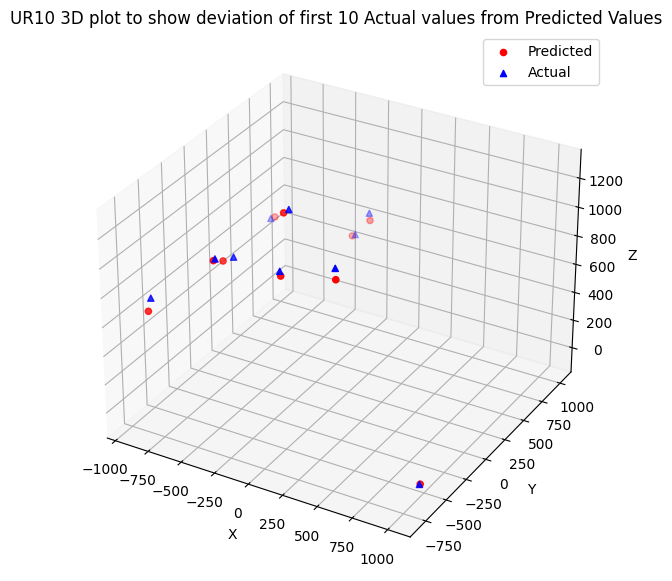

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Limit the plot to the first 5 rows.
ur10_result_df_first_5 = ur10_result_df.head(10)

# Create a 3D scatter plot.
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Extract the columns for predicted and actual coordinates for the first 20 rows.
x_predicted = ur10_result_df_first_5['x_predicted']
y_predicted = ur10_result_df_first_5['y_predicted']
z_predicted = ur10_result_df_first_5['z_predicted']
x_actual = ur10_result_df_first_5['x_actual']
y_actual = ur10_result_df_first_5['y_actual']
z_actual = ur10_result_df_first_5['z_actual']

# Plot predicted positions as red points.
ax.scatter(x_predicted, y_predicted, z_predicted, c='red', label='Predicted', marker='o')

# Plot actual positions as blue points.
ax.scatter(x_actual, y_actual, z_actual, c='blue', label='Actual', marker='^')

# Set labels and legend.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(['Predicted', 'Actual'])

# Add a title to the plot.
plt.title('UR10 3D plot to show deviation of first 10 Actual values from Predicted Values')

# Show the 3D plot.
plt.show()

4. **The KUKA KR AGILUS industrial robot.**

**OVERVIEW**:
The KUKA KR AGILUS is a series of compact industrial robot arms manufactured by KUKA Robotics, a German robotics company known for its innovative automation solutions.

They were initially designed to be fast, precise, and versatile, making it well-suited for various applications in industries like automotive, electronics, plastics, and more

 Despite its compact size, the KR AGILUS robot offers high payload capacities and exceptional performance, making it ideal for tasks that require agility and accuracy.

**KEY FEATURES**:
Compact Design, High Payload Capacity, Fast Speed and High Precision, Six Degrees of Freedom (6-DOF), Safety Features, User-Friendly Programming, Variety of Configurations, and High Repeatability.

**HISTORY**:
KUKA Robotics has a rich history in industrial robotics, dating back to its founding in 1898. The company has been a pioneer in developing advanced automation solutions for various industries.

The specific KR AGILUS series was introduced later, but my information only goes up to September 2021, and I don't have access to real-time data to provide the most recent history or updates.

The KR AGILUS robots were introduced as part of KUKA's efforts to expand its robot portfolio and offer a compact and agile solution for customers with limited workspace or specific automation needs.

Over the years, the series may have seen updates and improvements in terms of performance, software, and additional features to cater to evolving industry requirements. A picture of the arm can be shown below;

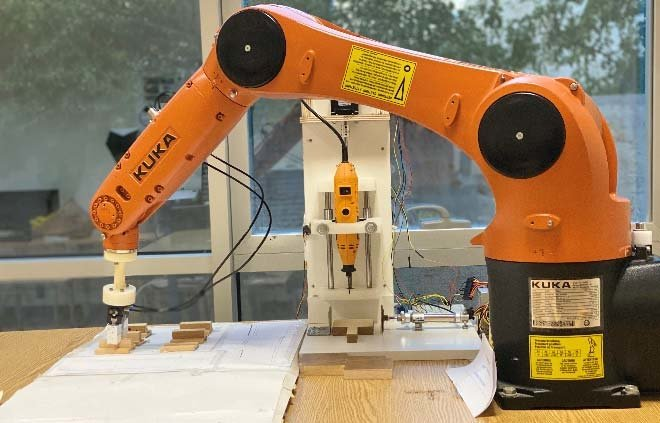

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/kuka.png')

The DH parameter table can also be shown below;

In [4]:
from IPython.display import Image
Image('/content/drive/MyDrive/dh_kuka.jpg')

Output hidden; open in https://colab.research.google.com to view.

The end effector positions from various joint angles for this robot arm is generated also using joint restrictions from the manufacturer's manual and the data is exported and stored in a csv file. This data is what is split into training and test data to train and evaluate the Tensorflow model.

Similar approach was used here as in the first `abb` arm.

In [ ]:
#Import the necessary libraries.
import numpy as np
import math # For mathematical operations.
import csv #To save generated training and test data into a csv file.


# Function to generate random angles within specified ranges.
def generate_joint_angles():
    '''
    This function generates random angles within specified ranges.
    The angle ranges should be specified in radians form.
    '''
    joint1 = np.random.uniform(0, np.pi)  # 0-180 degrees.
    joint2 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint3 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint4 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint5 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint6 = np.random.uniform(0, np.pi)  # 0-180 degrees.
    return [joint1, joint2, joint3, joint4, joint5, joint6]


# Create a function that performs the forward kinematics of the robot manipulator.
def forward_kinematics(theta):
    '''
    This function takes in the theta values for the specific problem and calculates the corresponding end effector position.
    The theta values should be passed into the function in radians form too.
    '''
    # DH parameters for the KUKA KR5 AGILUS.
    a = [180, 600, 120, 0, 0, 0]  # link lengths (mm).
    alpha = [np.pi/2, np.pi, -np.pi/2, np.pi/2, -np.pi/2, 0]  # link twists.
    d = [400, 135, 135, 620, 0, 115]  # link offsets (mm).

    # Homogeneous transformation matrices.
    T = np.eye(4)  # initial transformation matrix(identity matrix).

    for i in range(len(theta)):
        # Call parameters for transformation matrix.
        cos_theta = np.cos(theta[i])
        sin_theta = np.sin(theta[i])
        cos_alpha = np.cos(alpha[i])
        sin_alpha = np.sin(alpha[i])

        # Denavit-Hartenberg transformation matrix.
        A = np.array([[cos_theta, -sin_theta*cos_alpha, sin_theta*sin_alpha, a[i]*cos_theta],
                      [sin_theta, cos_theta*cos_alpha, -cos_theta*sin_alpha, a[i]*sin_theta],
                      [0, sin_alpha, cos_alpha, d[i]],
                      [0, 0, 0, 1]])

        # Update transformation matrix.
        T = np.dot(T, A)

        # Extract end effector position from the transformation matrix.
        end_effector_pos = T[:3, 3]
        # Create the quarternion representation of the XYZW-rotation.
        m_00 = T[0, 0]
        m_01 = T[0, 1]
        m_02 = T[0, 2]
        m_10 = T[1, 0]
        m_11 = T[1, 1]
        m_12 = T[1, 2]
        m_20 = T[2, 0]
        m_21 = T[2, 1]
        m_22 = T[2, 2]

        w = math.sqrt((1 + m_00 + m_11 + m_22)/2)
        x = (m_21 - m_12)/(4 * w)
        y = (m_02 - m_20)/(4 * w)
        z = (m_10 - m_01)/(4 * w)

        quart = np.array([w, x, y, z])

        final_pos = np.concatenate((end_effector_pos, quart))
    return final_pos

# Generate 100,000 random sets of joint angles.
np.random.seed(123)  # For reproducibility.
joint_angles = np.array([generate_joint_angles() for _ in range(100000)])  # Generate angles separately for each joint.

# Calculate forward kinematics for each set of joint angles.
final_positions = []
for angles in joint_angles:  #The angles variable has 6 entries which are angles for each joint in the manipulator.
    position = forward_kinematics(angles)
    final_positions.append(position)

final_positions = np.array(final_positions)

# Combine joint angles and end effector positions.
data = np.hstack((joint_angles, final_positions)) #Horizontally stacks up the joint parameters with the corresponding end effector position produced.

# Save joint angles and end effector positions to CSV file.
with open('joint_positions_kuka.csv', 'w', newline='') as file: #The `newline` argument is used to ensure that the CSV file is written with consistent newline characters.
    writer = csv.writer(file) #To write to the csv file.
    writer.writerow(['Joint1', 'Joint2', 'Joint3', 'Joint4', 'Joint5', 'Joint6', 'X', 'Y', 'Z', 'q1', 'q2', 'q3', 'q4'])  # Write header with xyz being the end effector position in space and q1, q2, q3, q4 representing the quarternion representations.
    writer.writerows(data) # Writes rows of entries to the csv file from the data we stacked using `np.hstack()`.

print("CSV file generated successfully.")

CSV file generated successfully.


The training and test data contains various joint parameters for this robot arm and the corresponding end effector position these joint parameters will give.

 This arm analysis also considered two TensorFlow models just like the for `abb` arm.

In [ ]:
#Import the necesarry libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Load the CSV data.
kuka_data = pd.read_csv('/content/drive/MyDrive/joint_positions_kuka.csv')

# Split features (input) and labels (output).
kuka_labels = kuka_data.iloc[:, :-7].values  # First 6 columns are labels.
kuka_features = kuka_data.iloc[:, -7:].values  # Last seven columns (x, y, z)

# Split data into training, validation, and test sets.
kuka_x_train, kuka_x_test, kuka_y_train, kuka_y_test = train_test_split(
    kuka_features, kuka_labels, test_size=0.2, random_state=42)

# Define the first TensorFlow model for the first four outputs.
kuka_model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)  # Output the first four values.
])

# Define the second TensorFlow model for the last three outputs.
kuka_model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)  # Output the last three values.
])

# Compile both models.
optimizer_1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer_2 = tf.keras.optimizers.Adam(learning_rate=0.001)
kuka_model1.compile(optimizer=optimizer_1, loss='mean_squared_error')
kuka_model2.compile(optimizer=optimizer_2, loss='mean_squared_error')


# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)



# Train model1.
print("Training kuka model1...")
kuka_model1.fit(kuka_x_train, kuka_y_train[:, :3], epochs=20, batch_size=32, validation_data=(kuka_x_test, kuka_y_test[:, :3]), callbacks=[early_stopping])
print("Training of kuka model1 completed.")

# Train model2.
print("Training kuka model2...")
kuka_model2.fit(kuka_x_train, kuka_y_train[:, 3:], epochs=20, batch_size=32, validation_data=(kuka_x_test, kuka_y_test[:, 3:]), callbacks=[early_stopping])
print("Training of kuka model2 completed.")

# Make predictions using both models.
kuka_y_preds1 = kuka_model1.predict(kuka_x_test)
kuka_y_preds2 = kuka_model2.predict(kuka_x_test)

# Combine the predictions to form the final prediction variable.
kuka_final_predictions = np.hstack((kuka_y_preds1, kuka_y_preds2))

# Evaluate the combined model's performance.
mse = np.mean(np.square(kuka_final_predictions - kuka_y_test))
print('Mean Squared Error (Combined Model):', mse)


# Calculate the mean of the actual target values from the test set (mean_y_test).
kuka_mean_y_test = np.mean(kuka_y_test, axis=0)

# Calculate the total sum of squares (TSS).
kuka_TSS = np.sum(np.square(kuka_y_test - kuka_mean_y_test))

# Calculate the RSS (residual sum of squares).
kuka_RSS = np.sum(np.square(kuka_y_test - kuka_final_predictions))

# Calculate R-squared (R²).
kuka_R_squared = 1 - (kuka_RSS / kuka_TSS)

print("R-squared value:", kuka_R_squared)

Training kuka model1...
Epoch 1/20
2500/2500 [==============================] - 27s 10ms/step - loss: 0.0773 - val_loss: 0.0119
Epoch 2/20
2500/2500 [==============================] - 28s 11ms/step - loss: 0.0114 - val_loss: 0.0101
Epoch 3/20
2500/2500 [==============================] - 26s 10ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 4/20
2500/2500 [==============================] - 26s 11ms/step - loss: 0.0065 - val_loss: 0.0059
Epoch 5/20
2500/2500 [==============================] - 24s 10ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 6/20
2500/2500 [==============================] - 24s 9ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 7/20
2500/2500 [==============================] - 26s 10ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 8/20
2500/2500 [==============================] - 24s 10ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 9/20
2500/2500 [==============================] - 24s 9ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/20
2500/2500 [===================

### Save the KUKA models.

In [ ]:
# Save the kuka models to a file.
kuka_model1.save('kuka_model1.h5')
kuka_model2.save('kuka_model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Save the KUKA predicted data.

In [ ]:
import pandas as pd

# Convert the NumPy array to a DataFrame.
predicted_data = pd.DataFrame(kuka_final_predictions, columns=['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6'])

# Save the DataFrame to a CSV file.
predicted_data.to_csv('Kuka_predicted_data.csv', index=False)

### Save the KUKA test data.

In [ ]:
import pandas as pd

# Convert the NumPy array to a DataFrame.
kuka_test_data = pd.DataFrame(kuka_y_test, columns=['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6'])

# Save the DataFrame to a CSV file.
kuka_test_data.to_csv('kuka_test_data.csv', index=False)

Kuka forward_kinematics function.

In [ ]:
# Create a function that performs the forward kinematics of the robot manipulator.
def forward_kinematics(theta):
    '''
    This function takes in the theta values for the specific problem and calculates the corresponding end effector position.
    The theta values should be passed into the function in radians form too.
    '''
    # DH parameters for the KUKA KR5 AGILUS.
    a = [180, 600, 120, 0, 0, 0]  # link lengths (mm).
    alpha = [np.pi/2, np.pi, -np.pi/2, np.pi/2, -np.pi/2, 0]  # link twists.
    d = [400, 135, 135, 620, 0, 115]  # link offsets (mm).

    # Homogeneous transformation matrices.
    T = np.eye(4)  # initial transformation matrix(identity matrix).

    for i in range(len(theta)):
        # Call parameters for transformation matrix.
        cos_theta = np.cos(theta[i])
        sin_theta = np.sin(theta[i])
        cos_alpha = np.cos(alpha[i])
        sin_alpha = np.sin(alpha[i])

        # Denavit-Hartenberg transformation matrix.
        A = np.array([[cos_theta, -sin_theta*cos_alpha, sin_theta*sin_alpha, a[i]*cos_theta],
                      [sin_theta, cos_theta*cos_alpha, -cos_theta*sin_alpha, a[i]*sin_theta],
                      [0, sin_alpha, cos_alpha, d[i]],
                      [0, 0, 0, 1]])

        # Update transformation matrix.
        T = np.dot(T, A)

        # Extract end effector position from the transformation matrix.
        end_effector_pos = T[:3, 3]
        # Create the quarternion representation of the XYZW-rotation.
        m_00 = T[0, 0]
        m_01 = T[0, 1]
        m_02 = T[0, 2]
        m_10 = T[1, 0]
        m_11 = T[1, 1]
        m_12 = T[1, 2]
        m_20 = T[2, 0]
        m_21 = T[2, 1]
        m_22 = T[2, 2]

        w = math.sqrt((1 + m_00 + m_11 + m_22)/2)
        x = (m_21 - m_12)/(4 * w)
        y = (m_02 - m_20)/(4 * w)
        z = (m_10 - m_01)/(4 * w)

        quart = np.array([w, x, y, z])

        final_pos = np.concatenate((end_effector_pos, quart))
    return final_pos

Load predicted and test data.

In [ ]:
import pandas as pd

kuka_predicted_data = pd.read_csv('/content/Kuka_predicted_data (1).csv')
kuka_test_data = pd.read_csv('/content/drive/MyDrive/kuka_test_data.csv')


Combine xyz positions of predicted and actual data into one csv file.

In [ ]:
import numpy as np
import math
# Create empty lists to store end-effector positions
x_predicted = []
y_predicted = []
z_predicted = []
x_actual = []
y_actual = []
z_actual = []

# Iterate through the rows of both datasets
for index, row in kuka_predicted_data.iterrows():
    # Extract joint angles from the dataset row
    joint_angles_predicted = row[['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6']]
    joint_angles_actual = kuka_test_data.loc[index, ['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6']]

    # Calculate end-effector positions using forward kinematics
    end_effector_pos_predicted = forward_kinematics(joint_angles_predicted)[:3]
    end_effector_pos_actual = forward_kinematics(joint_angles_actual)[:3]

    # Append the calculated positions to the lists
    x_predicted.append(end_effector_pos_predicted[0])
    y_predicted.append(end_effector_pos_predicted[1])
    z_predicted.append(end_effector_pos_predicted[2])
    x_actual.append(end_effector_pos_actual[0])
    y_actual.append(end_effector_pos_actual[1])
    z_actual.append(end_effector_pos_actual[2])

# Create a new DataFrame with the calculated end-effector positions
kuka_result_df = pd.DataFrame({
    'x_predicted': x_predicted,
    'y_predicted': y_predicted,
    'z_predicted': z_predicted,
    'x_actual': x_actual,
    'y_actual': y_actual,
    'z_actual': z_actual
})

# Save the combined DataFrame to a CSV file
kuka_result_df.to_csv('kuka_end_effector_positions.csv', index=False)


Create a 3D plot to show the deviations of predicted end effector positions from actual end effector positions.


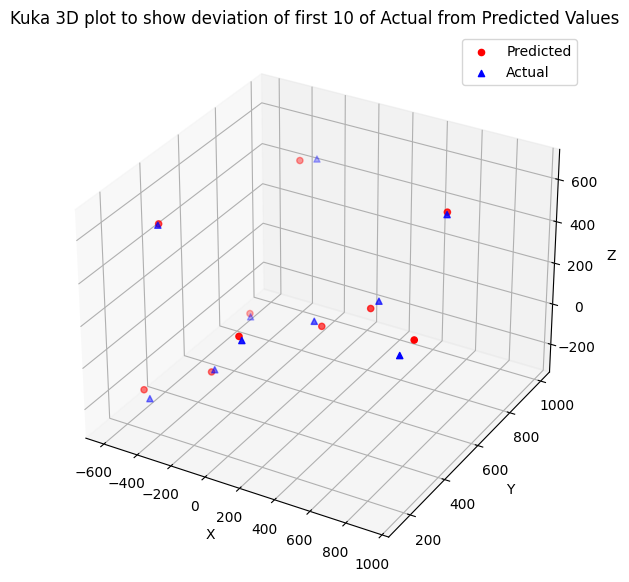

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Limit the plot to the first 5 rows.
kuka_result_df_first_5 = kuka_result_df.head(10)

# Create a 3D scatter plot.
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Extract the columns for predicted and actual coordinates for the first 20 rows.
x_predicted = kuka_result_df_first_5['x_predicted']
y_predicted = kuka_result_df_first_5['y_predicted']
z_predicted = kuka_result_df_first_5['z_predicted']
x_actual = kuka_result_df_first_5['x_actual']
y_actual = kuka_result_df_first_5['y_actual']
z_actual = kuka_result_df_first_5['z_actual']

# Plot predicted positions as red points.
ax.scatter(x_predicted, y_predicted, z_predicted, c='red', label='Predicted', marker='o')

# Plot actual positions as blue points.
ax.scatter(x_actual, y_actual, z_actual, c='blue', label='Actual', marker='^')

# Set labels and legend.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(['Predicted', 'Actual'])

# Add a title to the plot.
plt.title('Kuka 3D plot to show deviation of first 10 of Actual from Predicted Values')

# Show the 3D plot.
plt.show()

5. **The Yasakawa Motoman GP series.**

**OVERVIEW**:
The Yasakawa Motoman GP series is a family of industrial robot armsnthat are designed and manufactured by Yaskawa Electric Corporation's Motoman Robotics division. They can used for various automation applications in industries such as automotive, electronics, metalworking, and more. This is because they are mostly known for its versatility, high performance, and reliability, making it a popular choice for industrial automation tasks.

**KEY FEATURES**
Some of the key features of the Yasakawa Motoman GP series includes; High Payload Capacity, Extended Reach, Multiple Degrees of Freedom (DOF), High Speed and Precision, User-Friendly Programming and Control, Safety Features, Flexibility and Repeatability.

**HISTORY**:
Yaskawa Electric Corporation is a leading Japanese robotics company that has been at the forefront of industrial automation and robotics since its founding in 1915. The company introduced its first industrial robot, the MH1, in 1977, and it marked the beginning of Yaskawa's successful journey in the robotics industry. Over the years, Yaskawa has continuously improved its robot technology and introduced various robot series to meet the evolving needs of industrial automation. The Motoman brand was established in the 1980s, and since then, the Motoman robots have gained a strong reputation for their performance, quality, and innovation. The GP series, like other Motoman robot series, has seen several generations and updates with advancements in technology and design. Each new generation typically brings improvements in terms of payload capacity, reach, precision, speed, and user-friendly features.

This analysis focuses on the Yasakawa Motoman GP7 model of the GP series. A picture of the arm can be shown below.

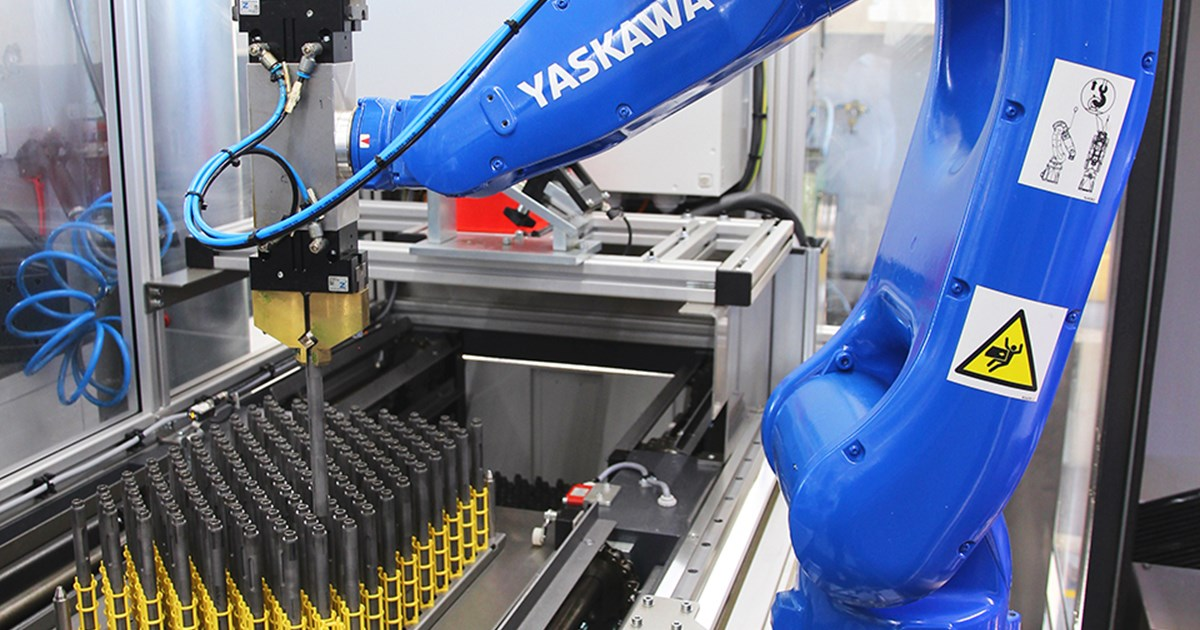

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/gp7.jpg')

The DH parameter table can also be shown below;

In [7]:
from IPython.display import Image
Image('/content/drive/MyDrive/dh_yasakawa.jpg')

Output hidden; open in https://colab.research.google.com to view.

The end effector positions from various joint angles for this robot arm is generated also using joint restrictions from the manufacturer's manual and the data is exported and stored in a csv file. This data is what is split into training and test data to train and evaluate the Tensorflow model.

Similar approach was used here as in the first `abb` arm.

In [ ]:
#Import the necessary libraries
import numpy as np
import math # For mathematical operations.
import csv #To save generated training and test data into a csv file.

# Function to generate random angles within specified ranges.
def generate_joint_angles():
    '''
    This function generates random angles within specified ranges.
    The angle ranges should be specified in radians form.
    '''
    joint1 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint2 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint3 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint4 = np.random.uniform(0, np.pi * 0.5)  # 0-90 degrees.
    joint5 =np.random.uniform(0, np.pi)  # 0-180 degrees.
    joint6 = np.random.uniform(0, np.pi)  # 0-180 degrees.
    return [joint1, joint2, joint3, joint4, joint5, joint6]


# Create a function that performs the forward kinematics of the robot manipulator.
def forward_kinematics(theta):
    '''
    This function takes in the theta values for the specific problem and calculates the corresponding end effector position.
    The theta values should be passed into the function in radians form too.
    '''
    # DH parameters for the yasakawa.
    a = [40, 445, 40, 0, 0, 0]  # link lengths (mm).
    alpha = [0, 0, 0, np.pi/2, -np.pi/2, -np.pi/2]  # link twists.
    d = [330, 0, 0, 440, 0, 80]  # link offsets (mm).

    # Homogeneous transformation matrices.
    T = np.eye(4)  # initial transformation matrix(identity matrix).

    for i in range(len(theta)):
        # Call parameters for transformation matrix.
        cos_theta = np.cos(theta[i])
        sin_theta = np.sin(theta[i])
        cos_alpha = np.cos(alpha[i])
        sin_alpha = np.sin(alpha[i])

        # Denavit-Hartenberg transformation matrix.
        A = np.array([[cos_theta, -sin_theta*cos_alpha, sin_theta*sin_alpha, a[i]*cos_theta],
                      [sin_theta, cos_theta*cos_alpha, -cos_theta*sin_alpha, a[i]*sin_theta],
                      [0, sin_alpha, cos_alpha, d[i]],
                      [0, 0, 0, 1]])

        # Update transformation matrix..
        T = np.dot(T, A)

        # Extract end effector position from the transformation matrix.
        end_effector_pos = T[:3, 3]
        # Create the quarternion representation of the XYZW-rotation.
        m_00 = T[0, 0]
        m_01 = T[0, 1]
        m_02 = T[0, 2]
        m_10 = T[1, 0]
        m_11 = T[1, 1]
        m_12 = T[1, 2]
        m_20 = T[2, 0]
        m_21 = T[2, 1]
        m_22 = T[2, 2]

        w = math.sqrt((1 + m_00 + m_11 + m_22)/2)
        x = (m_21 - m_12)/(4 * w)
        y = (m_02 - m_20)/(4 * w)
        z = (m_10 - m_01)/(4 * w)

        quart = np.array([w, x, y, z])

        final_pos = np.concatenate((end_effector_pos, quart))
    return final_pos

# Generate 100,000 random sets of joint angles.
np.random.seed(123)  # For reproducibility.
joint_angles = np.array([generate_joint_angles() for _ in range(100000)])  # Generate angles separately for each joint.

# Calculate forward kinematics for each set of joint angles.
final_positions = []
for angles in joint_angles:  #The angles variable has 6 entries which are angles for each joint in the manipulator.
    position = forward_kinematics(angles)
    final_positions.append(position)

final_positions = np.array(final_positions)

# Combine joint angles and end effector positions.
data = np.hstack((joint_angles, final_positions)) #Horizontally stacks up the joint parameters with the corresponding end effector position produced.

# Save joint angles and end effector positions to CSV file.
with open('joint_positions_gp7.csv', 'w', newline='') as file: #The `newline` argument is used to ensure that the CSV file is written with consistent newline characters.
    writer = csv.writer(file) #To write to the csv file.
    writer.writerow(['Joint1', 'Joint2', 'Joint3', 'Joint4', 'Joint5', 'Joint6', 'X', 'Y', 'Z', 'q1', 'q2', 'q3', 'q4'])  # Write header with xyz being the end effector position in space and q1, q2, q3, q4 representing the quarternion representations.
    writer.writerows(data) # Writes rows of entries to the csv file from the data we stacked using `np.hstack()`.

print("CSV file generated successfully.")

CSV file generated successfully.


The training and test data contains various joint parameters for this robot arm and the corresponding end effector position these joint parameters will give.

 This arm analysis also considered two TensorFlow models just like the for `abb` arm.

In [ ]:
#Import the necesarry libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Load the CSV data.
gp7_data = pd.read_csv('/content/drive/MyDrive/joint_positions_gp7.csv')

# Split features (input) and labels (output).
gp7_labels = gp7_data.iloc[:, :-7].values  # All columns except the last seven.
gp7_features = gp7_data.iloc[:, -7:].values  # Last seven columns (x, y, z).

# Split data into training, validation, and test sets.
gp7_x_train, gp7_x_test, gp7_y_train, gp7_y_test = train_test_split(
    gp7_features, gp7_labels, test_size=0.2, random_state=42)

# Define the first TensorFlow model for the first four outputs.
gp7_model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)  # Output the first four values.
])

# Define the second TensorFlow model for the last three outputs.
gp7_model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)  # Output the last three values.
])

# Compile both models.
optimizer_1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer_2 = tf.keras.optimizers.Adam(learning_rate=0.001)
gp7_model1.compile(optimizer=optimizer_1, loss='mean_squared_error')
gp7_model2.compile(optimizer=optimizer_2, loss='mean_squared_error')


# Define early stopping callback.
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)



# Train model1.
print("Training gp7 model1...")
gp7_model1.fit(gp7_x_train, gp7_y_train[:, :3], epochs=20, batch_size=32, validation_data=(gp7_x_test, gp7_y_test[:, :3]), callbacks=[early_stopping])
print("Training of gp7 model1 completed.")

# Train model2.
print("Training gp7 model2...")
gp7_model2.fit(gp7_x_train, gp7_y_train[:, 3:], epochs=20, batch_size=32, validation_data=(gp7_x_test, gp7_y_test[:, 3:]), callbacks=[early_stopping])
print("Training of gp7 model2 completed.")

# Make predictions using both models.
gp7_y_preds1 = gp7_model1.predict(gp7_x_test)
gp7_y_preds2 = gp7_model2.predict(gp7_x_test)

# Combine the predictions to form the final prediction variable.
gp7_final_predictions = np.hstack((gp7_y_preds1, gp7_y_preds2))

# Evaluate the combined model's performance.
mse = np.mean(np.square(gp7_final_predictions - gp7_y_test))
print('Mean Squared Error (Combined Model):', mse)


# Calculate the mean of the actual target values from the test set (mean_y_test).
gp7_mean_y_test = np.mean(gp7_y_test, axis=0)

# Calculate the total sum of squares (TSS).
gp7_TSS = np.sum(np.square(gp7_y_test - gp7_mean_y_test))

# Calculate the RSS (residual sum of squares).
gp7_RSS = np.sum(np.square(gp7_y_test - gp7_final_predictions))

# Calculate R-squared (R²).
gp7_R_squared = 1 - (gp7_RSS / gp7_TSS)

print("R-squared value:", gp7_R_squared)

Training gp7 model1...
Epoch 1/20
2500/2500 [==============================] - 27s 9ms/step - loss: 0.1498 - val_loss: 0.1343
Epoch 2/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.1345 - val_loss: 0.1327
Epoch 3/20
2500/2500 [==============================] - 26s 10ms/step - loss: 0.1331 - val_loss: 0.1344
Epoch 4/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.1327 - val_loss: 0.1377
Epoch 5/20
2500/2500 [==============================] - 23s 9ms/step - loss: 0.1314 - val_loss: 0.1273
Epoch 6/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.1307 - val_loss: 0.1280
Epoch 7/20
2500/2500 [==============================] - 24s 10ms/step - loss: 0.1296 - val_loss: 0.1283
Epoch 8/20
2500/2500 [==============================] - 24s 9ms/step - loss: 0.1291 - val_loss: 0.1273
Epoch 9/20
2500/2500 [==============================] - 25s 10ms/step - loss: 0.1290 - val_loss: 0.1318
Training of gp7 model1 completed.
Training g

### Save the GP7 models.

In [ ]:
# Save the gp7 models to a file.
gp7_model1.save('gp7_model1.h5')
gp7_model2.save('gp7_model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Save the GP7 predicted data.

In [ ]:
import pandas as pd

# Convert the NumPy array to a DataFrame.
predicted_data = pd.DataFrame(gp7_final_predictions, columns=['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6'])

# Save the DataFrame to a CSV file.
predicted_data.to_csv('gp7_predicted_data.csv', index=False)

### Save the GP7 test data.

In [ ]:
import pandas as pd

# Convert the NumPy array to a DataFrame.
gp7_test_data = pd.DataFrame(gp7_y_test, columns=['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6'])

# Save the DataFrame to a CSV file.
gp7_test_data.to_csv('gp7_test_data.csv', index=False)

GP7 forward_kinematics function

In [ ]:
# Create a function that performs the forward kinematics of the robot manipulator.
def forward_kinematics(theta):
    '''
    This function takes in the theta values for the specific problem and calculates the corresponding end effector position.
    The theta values should be passed into the function in radians form too.
    '''
    # DH parameters for the yasakawa.
    a = [40, 445, 40, 0, 0, 0]  # link lengths (mm).
    alpha = [0, 0, 0, np.pi/2, -np.pi/2, -np.pi/2]  # link twists.
    d = [330, 0, 0, 440, 0, 80]  # link offsets (mm).

    # Homogeneous transformation matrices.
    T = np.eye(4)  # initial transformation matrix(identity matrix).

    for i in range(len(theta)):
        # Call parameters for transformation matrix.
        cos_theta = np.cos(theta[i])
        sin_theta = np.sin(theta[i])
        cos_alpha = np.cos(alpha[i])
        sin_alpha = np.sin(alpha[i])

        # Denavit-Hartenberg transformation matrix.
        A = np.array([[cos_theta, -sin_theta*cos_alpha, sin_theta*sin_alpha, a[i]*cos_theta],
                      [sin_theta, cos_theta*cos_alpha, -cos_theta*sin_alpha, a[i]*sin_theta],
                      [0, sin_alpha, cos_alpha, d[i]],
                      [0, 0, 0, 1]])

        # Update transformation matrix.
        T = np.dot(T, A)

        # Extract end effector position from the transformation matrix.
        end_effector_pos = T[:3, 3]
        # Create the quarternion representation of the XYZW-rotation.
        m_00 = T[0, 0]
        m_01 = T[0, 1]
        m_02 = T[0, 2]
        m_10 = T[1, 0]
        m_11 = T[1, 1]
        m_12 = T[1, 2]
        m_20 = T[2, 0]
        m_21 = T[2, 1]
        m_22 = T[2, 2]

        w = math.sqrt((1 + m_00 + m_11 + m_22)/2)
        x = (m_21 - m_12)/(4 * w)
        y = (m_02 - m_20)/(4 * w)
        z = (m_10 - m_01)/(4 * w)

        quart = np.array([w, x, y, z])

        final_pos = np.concatenate((end_effector_pos, quart))
    return final_pos

Load predicted and test data.

In [ ]:
import pandas as pd

gp7_predicted_data = pd.read_csv('/content/drive/MyDrive/gp7_predicted_data.csv')
gp7_test_data = pd.read_csv('/content/drive/MyDrive/gp7_test_data.csv')


Combine xyz positions of predicted and actual data into one csv file.


In [ ]:
import numpy as np
import math
# Create empty lists to store end-effector positions.
x_predicted = []
y_predicted = []
z_predicted = []
x_actual = []
y_actual = []
z_actual = []

# Iterate through the rows of both datasets.
for index, row in gp7_predicted_data.iterrows():
    # Extract joint angles from the dataset row.
    joint_angles_predicted = row[['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6']]
    joint_angles_actual = gp7_test_data.loc[index, ['joint1', 'joint2', 'joint3', 'joint4', 'joint5', 'joint6']]

    # Calculate end-effector positions using forward kinematics.
    end_effector_pos_predicted = forward_kinematics(joint_angles_predicted)[:3]
    end_effector_pos_actual = forward_kinematics(joint_angles_actual)[:3]

    # Append the calculated positions to the lists.
    x_predicted.append(end_effector_pos_predicted[0])
    y_predicted.append(end_effector_pos_predicted[1])
    z_predicted.append(end_effector_pos_predicted[2])
    x_actual.append(end_effector_pos_actual[0])
    y_actual.append(end_effector_pos_actual[1])
    z_actual.append(end_effector_pos_actual[2])

# Create a new DataFrame with the calculated end-effector positions.
gp7_result_df = pd.DataFrame({
    'x_predicted': x_predicted,
    'y_predicted': y_predicted,
    'z_predicted': z_predicted,
    'x_actual': x_actual,
    'y_actual': y_actual,
    'z_actual': z_actual
})

# Save the combined DataFrame to a CSV file.
gp7_result_df.to_csv('gp7_end_effector_positions.csv', index=False)


Create a 3D plot to show the deviations of predicted end effector positions from actual end effector positions.

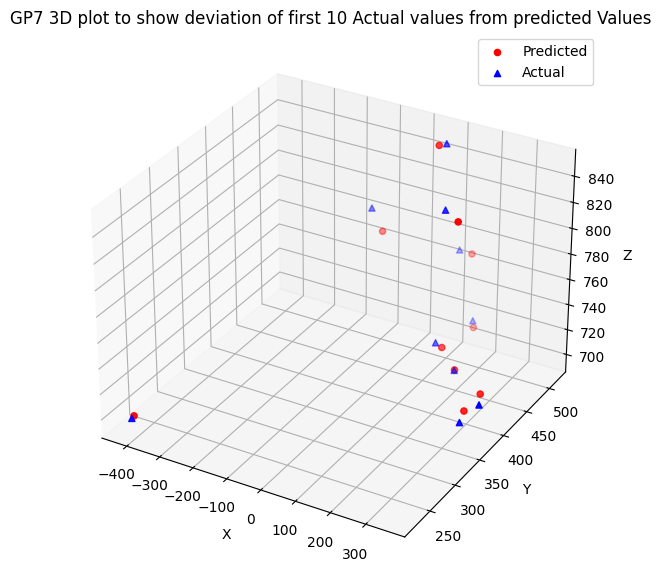

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

gp7_features_result_df = gp7_result_df
# Limit the plot to the first 5 rows.
gp7_result_df_first_5 = gp7_result_df.head(10)

# Create a 3D scatter plot.
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Extract the columns for predicted and actual coordinates for the first 20 rows.
x_predicted = gp7_result_df_first_5['x_predicted']
y_predicted = gp7_result_df_first_5['y_predicted']
z_predicted = gp7_result_df_first_5['z_predicted']
x_actual = gp7_result_df_first_5['x_actual']
y_actual = gp7_result_df_first_5['y_actual']
z_actual = gp7_result_df_first_5['z_actual']

# Plot predicted positions as red points.
ax.scatter(x_predicted, y_predicted, z_predicted, c='red', label='Predicted', marker='o')

# Plot actual positions as blue points.
ax.scatter(x_actual, y_actual, z_actual, c='blue', label='Actual', marker='^')

# Set labels and legend.
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(['Predicted', 'Actual'])

# Add a title to the plot.
plt.title('GP7 3D plot to show deviation of first 10 Actual values from predicted Values')

# Show the 3D plot.
plt.show()

### Now using this analysis on our live 4-dof manipulator.


The code for generating the training data is altered in the following ways.

  - The Denavit-hartenberg parameters a, alpha, and d were measured directly from the live model and used for analysis.
  - The range of theta values for the four revolute joints of the live model was gotten and also used to streamline the generated data for a much better training data.

In [ ]:
#Import the necessary libraries.
import numpy as np
import math
import csv

# Create a function that performs the forward kinematics of the robot manipulator.
def forward_kinematics_live_model(theta):
    """
    This function uses the Denavit-Hartenberg  method to solve the forward kinematics problem of our specific 4dof manipulator live model.
    It takes uses the various constant Denavit-Hartenberg parameters and takes in specific theta angles for the four revolute joints as argument.
    It uses this data to solve the forward kinematics problem of the robot manipulator and determine the respective end-effector position.
    """
    # DH parameters for the four degrees of freedom live model.
    a = [3.5, 0, 0, 0]  # link lengths (cm).
    alpha = [np.pi/2, 0, np.pi/2, 0]  # link twists (radians).
    d = [0 , 8, 8.2, 2.3]  # link offsets (cm).

    # Homogeneous transformation matrices.
    T = np.eye(4)  # initial transformation matrix(identity matrix).

    for i in range(len(theta)):
        # Call parameters for transformation matrix.
        cos_theta = np.cos(theta[i])
        sin_theta = np.sin(theta[i])
        cos_alpha = np.cos(alpha[i])
        sin_alpha = np.sin(alpha[i])

        # Denavit-Hartenberg transformation matrix.
        A = np.array([[cos_theta, -sin_theta*cos_alpha, sin_theta*sin_alpha, a[i]*cos_theta],
                      [sin_theta, cos_theta*cos_alpha, -cos_theta*sin_alpha, a[i]*sin_theta],
                      [0, sin_alpha, cos_alpha, d[i]],
                      [0, 0, 0, 1]])

        # Update transformation matrix.
        T = np.dot(T, A)

        # Extract end effector position from the transformation matrix.
        end_effector_pos = T[:3, 3]
        # Create the quarternion representation of the XYZW-rotation.
        m_00 = T[0, 0]
        m_01 = T[0, 1]
        m_02 = T[0, 2]
        m_10 = T[1, 0]
        m_11 = T[1, 1]
        m_12 = T[1, 2]
        m_20 = T[2, 0]
        m_21 = T[2, 1]
        m_22 = T[2, 2]

        w = math.sqrt((1 + m_00 + m_11 + m_22)/2)
        x = (m_21 - m_12)/(4 * w)
        y = (m_02 - m_20)/(4 * w)
        z = (m_10 - m_01)/(4 * w)

        quart = np.array([w, x, y, z])

        final_pos = np.concatenate((end_effector_pos, quart))
    return final_pos

# Generate 1,000,000 entries of 4 random angles following different ranges of each revolute joint of the robot arm.
np.random.seed(123)  # For reproducibility.
entries = np.empty((1000000, 4))
# Generate angles with specified ranges.
entries[:, 0] = np.random.uniform(0, np.pi, 1000000)
entries[:, 1] = np.random.uniform(0, np.pi, 1000000)
entries[:, 2] = np.random.uniform(0, np.pi, 1000000)
entries[:, 3] = np.random.uniform(0, (5/6)*(np.pi), 1000000)
joint_angles = entries  #This numpy array will have 1,000,000 columns with 4 rows each. Each row will represent the 4 angles for the 4 joints of the manipulator.



# Calculate forward kinematics for each set of joint angles.
final_positions = []
for angles in joint_angles:  #The angles variable has 6 entries which are angles for each joint in the manipulator.
    position = forward_kinematics_live_model(angles)
    final_positions.append(position)

final_positions = np.array(final_positions)

# Combine joint angles and end effector positions.
data = np.hstack((joint_angles, final_positions)) #Horizontally stacks up the joint parameters with the corresponding end effector position produced.

# Save joint angles and end effector positions to CSV file.
with open('joint_positions_4dof.csv', 'w', newline='') as file: # The `newline` argument is used to ensure that the CSV file is written with consistent newline characters.
    writer = csv.writer(file) #To write to the csv file.
    writer.writerow(['Joint1', 'Joint2', 'Joint3', 'Joint4', 'X', 'Y', 'Z', 'q1', 'q2', 'q3', 'q4'])  # Write header with xyz being the end effector position in space and q1, q2, q3, q4 representing the quarternion representations.
    writer.writerows(data) # Writes rows of entries to the csv file from the data we stacked using `np.hstack()`.

print("CSV file generated successfully.")

CSV file generated successfully.


Now we build and train the neural network model on this data generated.

   - This neural networks model will take in 7input layers (three being the end effector position in the xyz plane and four being the quarternion representation of the xyzw plane) and four output layers corresponding to the four joint parameters of the four revolute joints in the live model.
  
- The model is also evaluated with the loss parameter and an early-stopping callback was placed in case there was no improvement in the performance after 5 epochs.

In [ ]:
#Import the necesarry libraries.
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load the CSV data.
data = pd.read_csv('/content/drive/MyDrive/joint_positions_4dof (2).csv')

# Sample 100,000 rows from the full dataset.
data = data.sample(n=100000, random_state=42)


# Split features (input) and labels (output).
labels = data.iloc[:, :-7].values  # All columns except the last seven.
features = data.iloc[:, -7:].values  # Last seven columns (x, y, z).

# Split data into training, validation, and test sets.
x_train, x_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42)

# Define/Build the TensorFlow model.
four_dof_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(7,)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4)  # Output layer with 4 units for joint angles.
])

# Compile the model.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
four_dof_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define an early stopping callback.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss.
    patience=5,           # Stop training after 5 epochs with no improvement.
    restore_best_weights=True  # Restore the best model weights.
)


# Train the model.
four_dof_model.fit(x_train, y_train, epochs=20, batch_size=32)

# Evaluate the model on the test set.
loss = four_dof_model.evaluate(x_test, y_test)
print('Test Loss:', loss)

# Make predictions on the test set.
y_preds = four_dof_model.predict(x_test)

# Perform evaluation metrics (mean squared error).
mse = np.mean(np.square(y_preds - y_test))
print('Mean Squared Error:', mse)

# Since no in-built method for calculating the r-squared metric, Let's do it manually.
# Calculate the mean of the actual target values from the test set (mean_y_test).
mean_y_test = np.mean(y_test, axis=0)

# Calculate the total sum of squares (TSS).
TSS = np.sum(np.square(y_test - mean_y_test))

# Calculate the RSS (residual sum of squares).
y_preds = four_dof_model.predict(x_test)
RSS = np.sum(np.square(y_test - y_preds))

# Calculate R-squared (R²).
R_squared = 1 - (RSS / TSS)

print("R-squared value:", R_squared)

Epoch 1/20
2500/2500 [==============================] - 52s 20ms/step - loss: 0.2434
Epoch 2/20
2500/2500 [==============================] - 32s 13ms/step - loss: 0.2097
Epoch 3/20
2500/2500 [==============================] - 28s 11ms/step - loss: 0.2089
Epoch 4/20
2500/2500 [==============================] - 29s 11ms/step - loss: 0.2083
Epoch 5/20
2500/2500 [==============================] - 29s 12ms/step - loss: 0.2077
Epoch 6/20
2500/2500 [==============================] - 28s 11ms/step - loss: 0.2076
Epoch 7/20
2500/2500 [==============================] - 29s 12ms/step - loss: 0.2075
Epoch 8/20
2500/2500 [==============================] - 29s 12ms/step - loss: 0.2072
Epoch 9/20
2500/2500 [==============================] - 28s 11ms/step - loss: 0.2071
Epoch 10/20
2500/2500 [==============================] - 28s 11ms/step - loss: 0.2070
Epoch 11/20
2500/2500 [==============================] - 28s 11ms/step - loss: 0.2069
Epoch 12/20
2500/2500 [==============================] - 27s 11

In [ ]:
# Save y_test (actual joint angles) as a CSV file.
actual_4dof_df = pd.DataFrame(data=y_test, columns=['joint1', 'joint2', 'joint3', 'joint4'])
actual_4dof_df.to_csv('actual_4dof.csv', index=False)

print("Actual joint angles saved as 'actual_4dof.csv'")

Actual joint angles saved as 'actual_4dof.csv'


In [ ]:
# Save the entire model to a file.
four_dof_model.save('four_dof_model')

Four dof forward kinematics function

In [ ]:
# Create a function that performs the forward kinematics of the robot manipulator.
def forward_kinematics_live_model(theta):
    """
    This function uses the Denavit-Hartenberg  method to solve the forward kinematics problem of our specific 4dof manipulator live model.
    It takes uses the various constant Denavit-Hartenberg parameters and takes in specific theta angles for the four revolute joints as argument.
    It uses this data to solve the forward kinematics problem of the robot manipulator and determine the respective end-effector position.
    """
    # DH parameters for the four degrees of freedom live model.
    a = [3.5, 0, 0, 0]  # link lengths (cm).
    alpha = [np.pi/2, 0, np.pi/2, 0]  # link twists (radians).
    d = [0 , 8, 8.2, 2.3]  # link offsets (cm).

    # Homogeneous transformation matrices.
    T = np.eye(4)  # initial transformation matrix(identity matrix).

    for i in range(len(theta)):
        # Call parameters for transformation matrix.
        cos_theta = np.cos(theta[i])
        sin_theta = np.sin(theta[i])
        cos_alpha = np.cos(alpha[i])
        sin_alpha = np.sin(alpha[i])

        # Denavit-Hartenberg transformation matrix.
        A = np.array([[cos_theta, -sin_theta*cos_alpha, sin_theta*sin_alpha, a[i]*cos_theta],
                      [sin_theta, cos_theta*cos_alpha, -cos_theta*sin_alpha, a[i]*sin_theta],
                      [0, sin_alpha, cos_alpha, d[i]],
                      [0, 0, 0, 1]])

        # Update transformation matrix.
        T = np.dot(T, A)

        # Extract end effector position from the transformation matrix.
        end_effector_pos = T[:3, 3]
        # Create the quarternion representation of the XYZW-rotation.
        m_00 = T[0, 0]
        m_01 = T[0, 1]
        m_02 = T[0, 2]
        m_10 = T[1, 0]
        m_11 = T[1, 1]
        m_12 = T[1, 2]
        m_20 = T[2, 0]
        m_21 = T[2, 1]
        m_22 = T[2, 2]

        w = math.sqrt((1 + m_00 + m_11 + m_22)/2)
        x = (m_21 - m_12)/(4 * w)
        y = (m_02 - m_20)/(4 * w)
        z = (m_10 - m_01)/(4 * w)

        quart = np.array([w, x, y, z])

        final_pos = np.concatenate((end_effector_pos, quart))
    return final_pos

Load saved 4dof model.

In [ ]:
import tensorflow as tf
# Load the saved model.
#loaded_model = tf.keras.models.load_model('four_dof_model')
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/four_dof_model.h5')

Save the predicted joint angles for the dataset.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Load the CSV data.
data = pd.read_csv('/content/drive/MyDrive/joint_positions_4dof (2).csv')

# Sample 100,000 rows from the full dataset.
data = data.sample(n=100000, random_state=42)

# Split features (input) and labels (output).
labels = data.iloc[:, :-4].values  # All columns except the last four
features = data.iloc[:, -4:].values  # Last four columns (x, y, z)

# Make predictions on the test set
y_preds = four_dof_model.predict(x_test)

# Create a DataFrame for predictions
predictions_df = pd.DataFrame(data=y_preds, columns=['Predicted_Joint1', 'Predicted_Joint2', 'Predicted_Joint3', 'Predicted_Joint4'])

# Save the predictions DataFrame to a CSV file
predictions_df.to_csv('4dof_predictions.csv', index=False)

print("Predictions saved to '4dof_predictions.csv'")

625/625 [==============================] - 2s 3ms/step
Predictions saved to '4dof_predictions.csv'


Save predicted and actual values into one csv file.

In [ ]:
import pandas as pd
import numpy as np
import math

# Load the predicted joint angles CSV file
predicted_df = pd.read_csv('/content/4dof_predictions.csv')

# Load the actual joint angles CSV file
actual_df = pd.read_csv('/content/actual_4dof.csv')

# Initialize lists to store end-effector positions
x_predicted_list = []
y_predicted_list = []
z_predicted_list = []
x_actual_list = []
y_actual_list = []
z_actual_list = []

# Iterate through rows of both DataFrames
for index, (predicted_row, actual_row) in enumerate(zip(predicted_df.iterrows(), actual_df.iterrows())):
    # Extract predicted joint angles from the predicted DataFrame
    predicted_joint_angles = predicted_row[1].values  # Assuming the joint angles are in order

    # Extract actual joint angles from the actual DataFrame
    actual_joint_angles = actual_row[1].values  # Assuming the joint angles are in order

    # Calculate end-effector positions for predicted joint angles
    predicted_end_effector = forward_kinematics_live_model(predicted_joint_angles)

    # Calculate end-effector positions for actual joint angles
    actual_end_effector = forward_kinematics_live_model(actual_joint_angles)

    # Append the positions to respective lists
    x_predicted_list.append(predicted_end_effector[0])
    y_predicted_list.append(predicted_end_effector[1])
    z_predicted_list.append(predicted_end_effector[2])
    x_actual_list.append(actual_end_effector[0])
    y_actual_list.append(actual_end_effector[1])
    z_actual_list.append(actual_end_effector[2])

# Create a DataFrame for the results
result_df = pd.DataFrame({
    'x_predicted': x_predicted_list,
    'y_predicted': y_predicted_list,
    'z_predicted': z_predicted_list,
    'x_actual': x_actual_list,
    'y_actual': y_actual_list,
    'z_actual': z_actual_list
})

# Save the DataFrame to a CSV file
result_df.to_csv('result_4dof.csv', index=False)

print("Results saved to 'result_4dof.csv'")


Results saved to 'result_4dof.csv'


3Dplot to show accuracy of 4dof model.

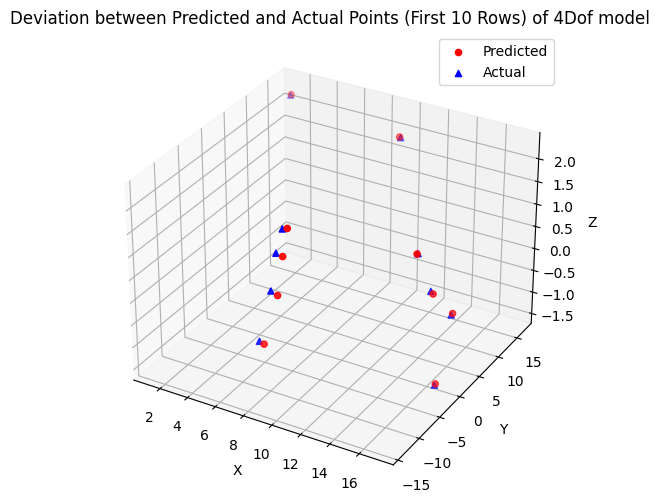

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the result_4dof.csv file
result_df = pd.read_csv('/content/result_4dof.csv')

# Select the first 10 rows
subset_df = result_df.head(10)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the predicted points as red markers
ax.scatter(subset_df['x_predicted'], subset_df['y_predicted'], subset_df['z_predicted'], c='red', label='Predicted', marker='o')

# Plot the actual points as blue markers
ax.scatter(subset_df['x_actual'], subset_df['y_actual'], subset_df['z_actual'], c='blue', label='Actual', marker='^')

# Set labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend(['Predicted', 'Actual'])

# Show the plot
plt.title('Deviation between Predicted and Actual Points (First 10 Rows) of 4Dof model')
plt.show()


In [ ]:
# Use forward kinematics to get the actual end effector positions a specific angle combination would give.
angle = [np.pi/3, np.pi/3, 0, 0]
end_pose = forward_kinematics_live_model(angle)

# Reshape end_pose to match the expected input shape of the model
end_pose = np.reshape(end_pose, (1, 7))

# Pass in the reshaped end effector positions to the machine learning model to predict the required angles for such end effector positions.
predicted_angles_radians = four_dof_model.predict(end_pose)

# Convert the predicted angles from radians to degrees
predicted_angles_degrees = np.degrees(predicted_angles_radians)

# Convert the degrees to a string separated by commas
predicted_angles_string = ', '.join([str(angle) for angle in predicted_angles_degrees[0]])

# Print the predicted angles as a comma-separated string
print("Predicted Angles (Degrees):", predicted_angles_string)

1/1 [==============================] - 0s 127ms/step
Predicted Angles (Degrees): 61.67524, 31.090569, 31.007797, 4.3850803


Now we can communicate our predicted servo angles directly to the arduino.

# Conclusion

In conclusion, this neural networks project has provided valuable insights and practical experience in the application of deep leaning into the field of robotics. Through the use of Tensorflow, Pandas, Matplolib, Seaborn, Numpy, etc. we successfully designed, trained, and evaluated neural network models for solving the inverse kinematics problem of both 6dof and 4dof manipulators.

We were able to achieve models performing impressively with r-squared value as high as 0.97 for the 6dof models, and r-squared value of 0.72 for the 4dof model.

Throughout the project, we encountered challenges, some of which are;
- Getting accurate and custom dh-parameters for the 6dof industrial arms.
- Generating and pre-processing the data in the right way for the models to be able to find patterns.
- Connecting the TensorFlow model with the arduino serial communicator.


 We also experimented with different architectures, fine-tuned hyperparameters, and conducted rigorous testing to achieve optimal results. The collaborative and cloud-based nature of Google Colab allowed for seamless teamwork, sharing of resources, and efficient model training, making it an invaluable asset for data scientists and machine learning practitioners.

As we move forward in the ever-evolving landscape of artificial intelligence, the knowledge and skills acquired during this project will serve as a solid foundation for tackling more complex problems and contributing to the broader field of machine learning.


In the future, we look forward to further experimentation, collaboration, and the application of neural networks to solve real-world challenges. As technology continues to advance, we remain dedicated to harnessing the power of artificial intelligence for the betterment of society. With the skills and experiences gained here, we are poised to make a meaningful impact in the field of neural networks and beyond.

Supervisor

Engr. Ebunkamaodo Odudu - odudu.ebunkamaodo@uniben.edu

`Author/Programmer` :- Agbonoga Dauda Okhumede - daudaagbonoga@gmail.com

Team members

Ahekobuwa Nosamudianaede Praise 	-  nosamudianaedeahekobuwa@gmail.com

Ahueansebhor Emmanuel Osemuahun		-  emmahueans99@gmail.com

Aihie Daniel Aisosa	- danielaisosaaihie@gmail.com
